# Initializations

## Imports

In [879]:
%load_ext autoreload
%autoreload 2

import datetime
from pathlib import Path

import dtcwt
import pywt
import numpy as np
from numpy.random import default_rng
import scipy as sp
import scipy.signal
import scipy.io as sio
import sklearn
import tensorflow as tf
import helpers
import add_labels
import features
import mpl_styles

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Styles

In [810]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault, font_manager
from matplotlib.patches import Rectangle

rcParams.update(rcParamsDefault)
plt.style.use(mpl_styles.presentation)
plt.style.use(mpl_styles.common)
CMAP = plt.get_cmap()
list_sizes = mpl_styles.list_sizes

## Paths

In [774]:
OUT_PATH_1 = Path('./out')
OUT_PATH = OUT_PATH_1 / 'gen2'
OUT_PATH.mkdir(exist_ok=True)

## Define helpers

### Plot all

In [693]:
def plot_all(data, classes,
             figaxs_time, figaxs_fourier, figaxs_spectre, figaxs_dtcwt, *,
             fs, dtcwt_levels, path_prefix):
    fig_t, axs_t = figaxs_time
    fig_f, axs_f = figaxs_fourier
    fig_sp, axs_sp = figaxs_spectre
    fig_dtcwt, axs_dtcwt = figaxs_dtcwt
    for cls, (cls_name, ax_t, ax_f, ax_sp, ax_dtcwt) in enumerate(zip(classes, axs_t.flatten(), axs_f.flatten(), axs_sp.flatten(), axs_dtcwt.flatten())):
        sample = data[cls, 0]
        ax_t.plot(sample)
        ax_t.set_title(cls_name)
        sample_labels(ax_t)
        ax_t.set_ylabel('Амплитуда, рад/с')

        ax_f.set_title(cls_name)
        ax_f.plot(*features.fourier(sample, 1/fs))
        fourier_labels(ax_f)

        ax_sp.grid(False)
        spec, freqs, t, im = ax_sp.specgram(sample, Fs=fs)
        cbar = fig_sp.colorbar(im, ax=ax_sp)
        cbar.ax.set_ylabel('Интенсивность, отн.ед.', rotation=270, va='bottom')
        ax_sp.set_title(cls_name)
        spec_labels(ax_sp)

        ax_dtcwt.grid(False)
        im = ax_dtcwt.imshow(features.dtcwt(sample, dtcwt_levels, False, True))
        cbar = fig_dtcwt.colorbar(im, ax=ax_dtcwt)
        cbar.ax.set_ylabel('Интенсивность, отн.ед.', rotation=270, va='bottom')
        ax_dtcwt.set_title(cls_name)
        dwt_labels(ax_dtcwt)
        
    for fig, name in zip((fig_t, fig_f, fig_sp, fig_dtcwt), ('time', 'fourier', 'spectre', 'dtcwt')):
        fig.tight_layout()
        fig.savefig(f'{path_prefix} {name}.png')

# Data 1

## Init dataset vars

In [865]:
import dataset_v as dsv

SAMPLE_LEN = dsv.SAMPLE_LEN
CLASSES = dsv.CLASSES
FS = dsv.FS
DT = dsv.DT

## Load raw

In [868]:
raw_data = dsv.load()
raw_data.shape

(9, 104, 3600)

## Fragmentize

In [675]:
NEW_SAMPLE_LEN = 1024
SAMPLE_SPLIT_N = raw_data.shape[2] // NEW_SAMPLE_LEN
raw_data_cropped = raw_data[:, :, :NEW_SAMPLE_LEN * SAMPLE_SPLIT_N].reshape(
    (
        raw_data.shape[0], 
        raw_data.shape[1] * SAMPLE_SPLIT_N, 
        NEW_SAMPLE_LEN,
    )
)
raw_data_cropped.shape

(9, 312, 1024)

## Plot features

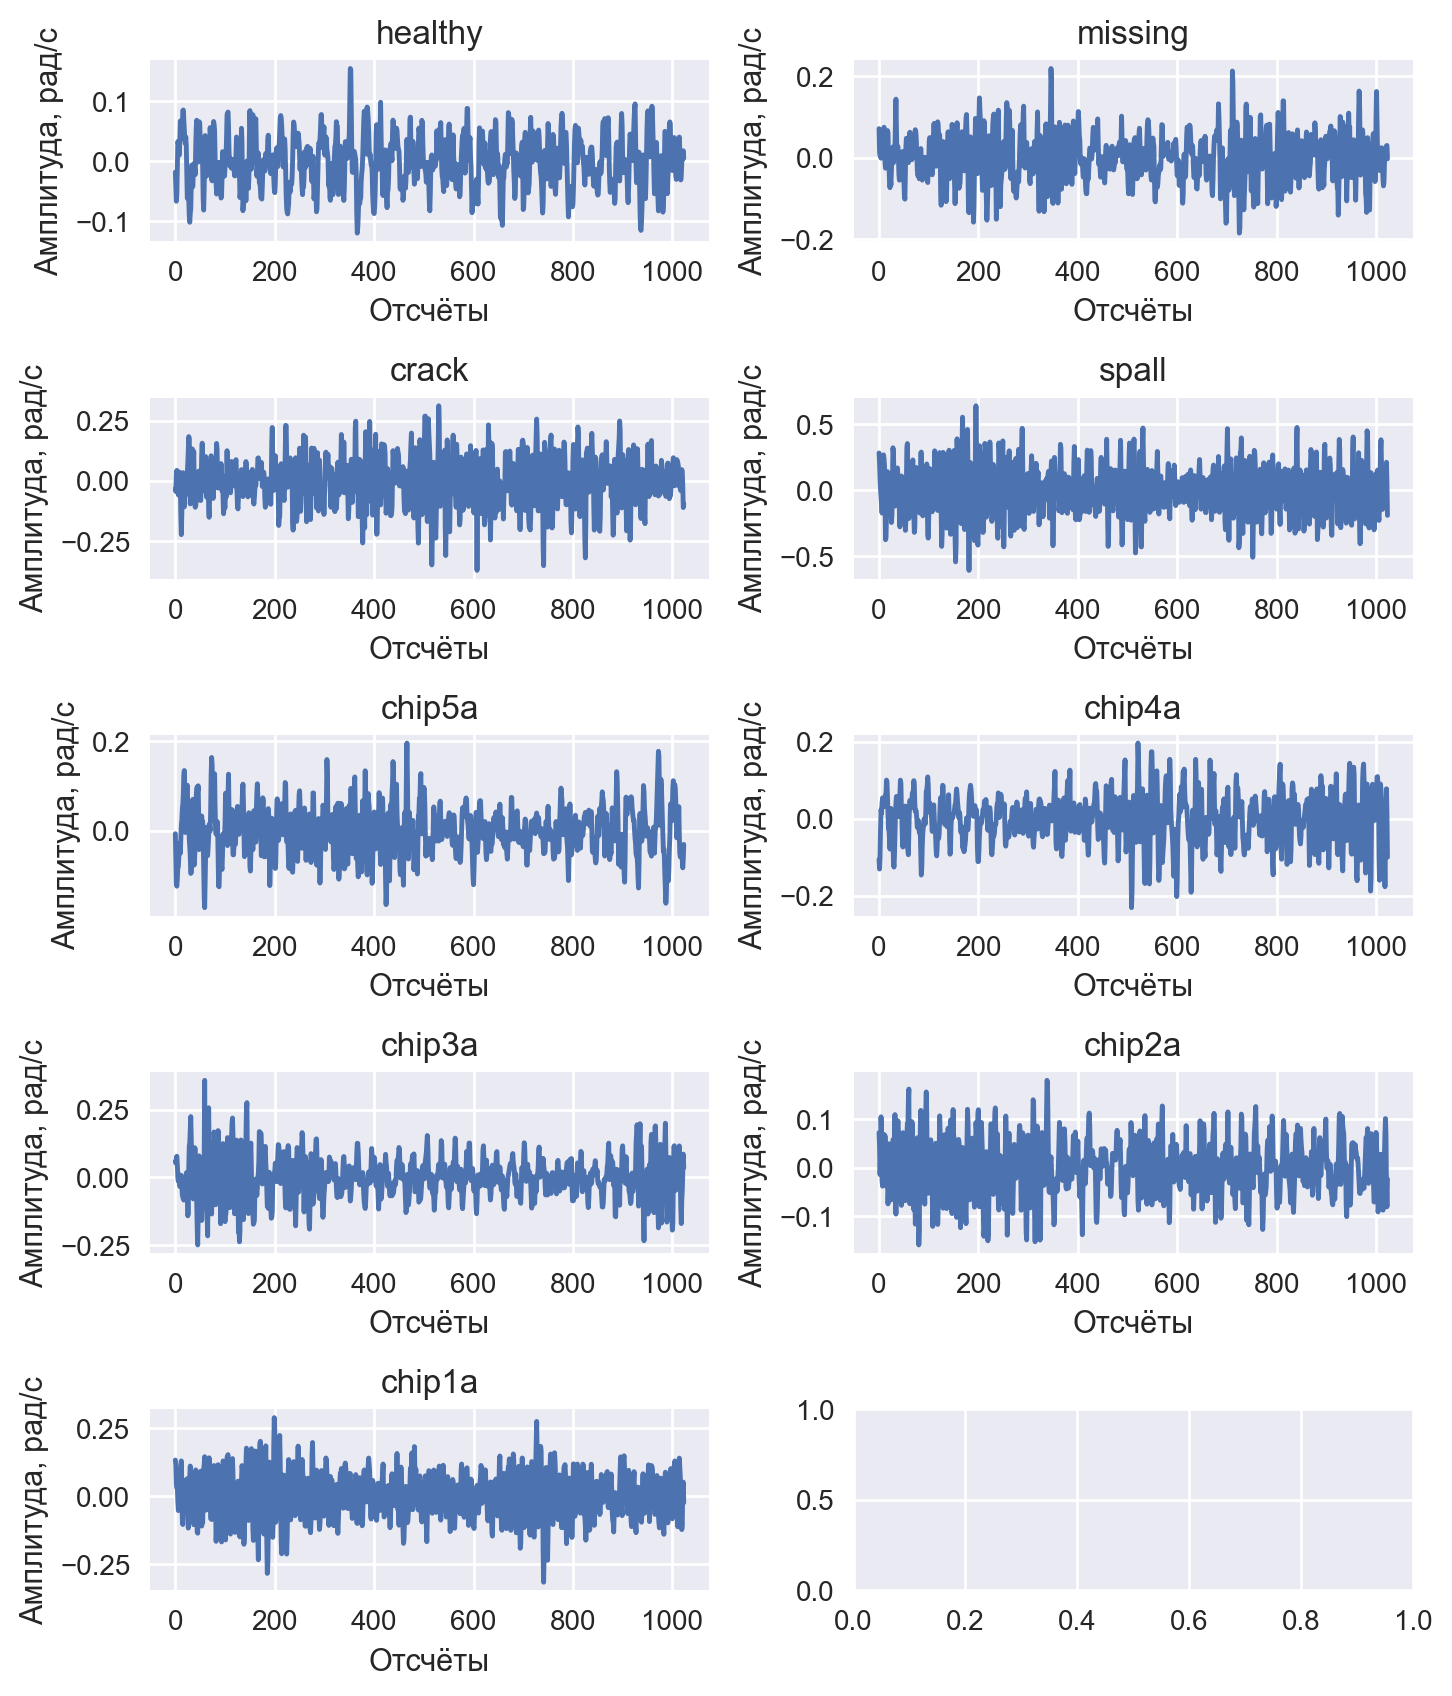

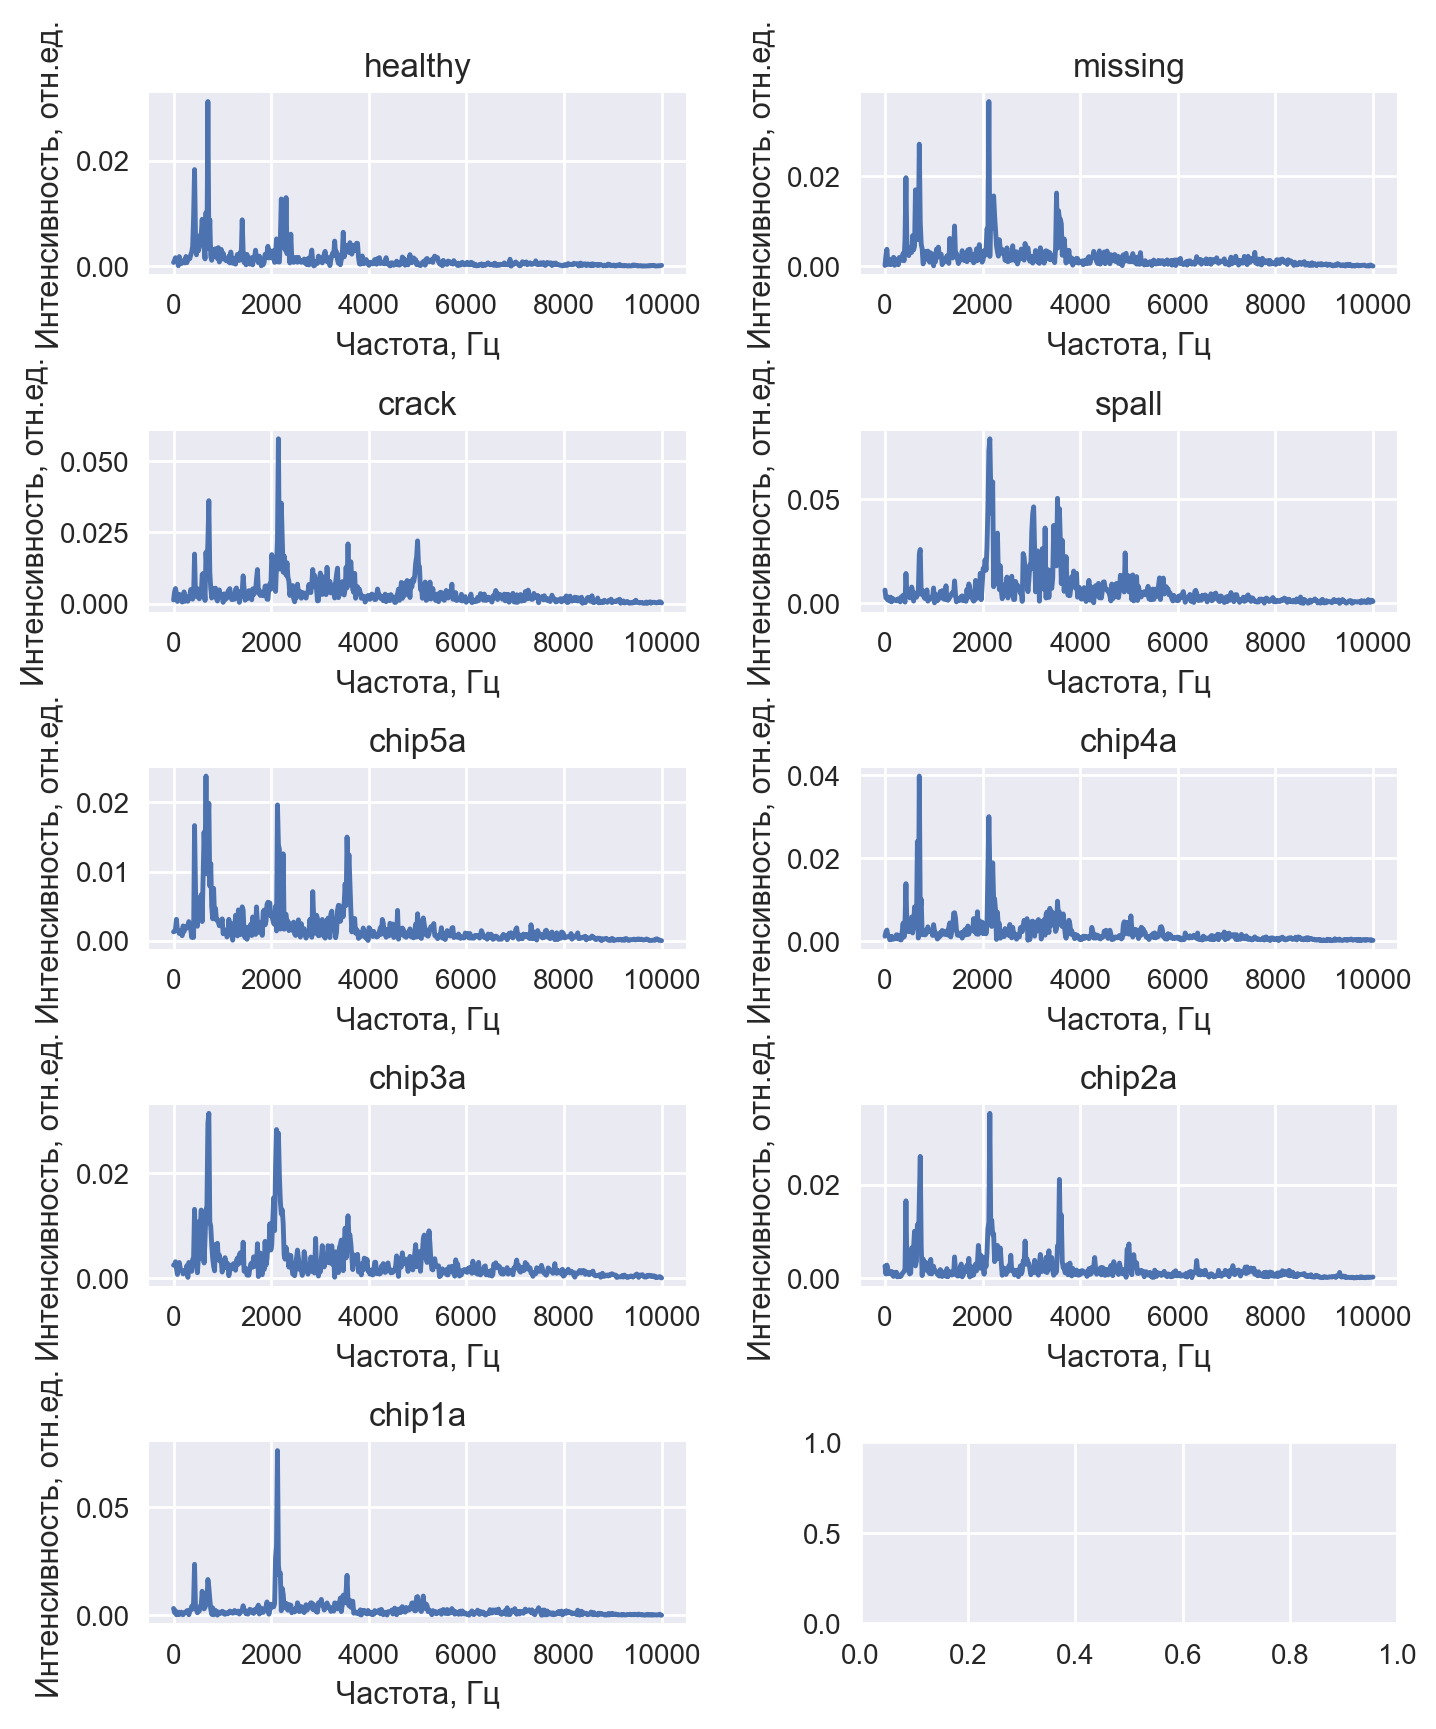

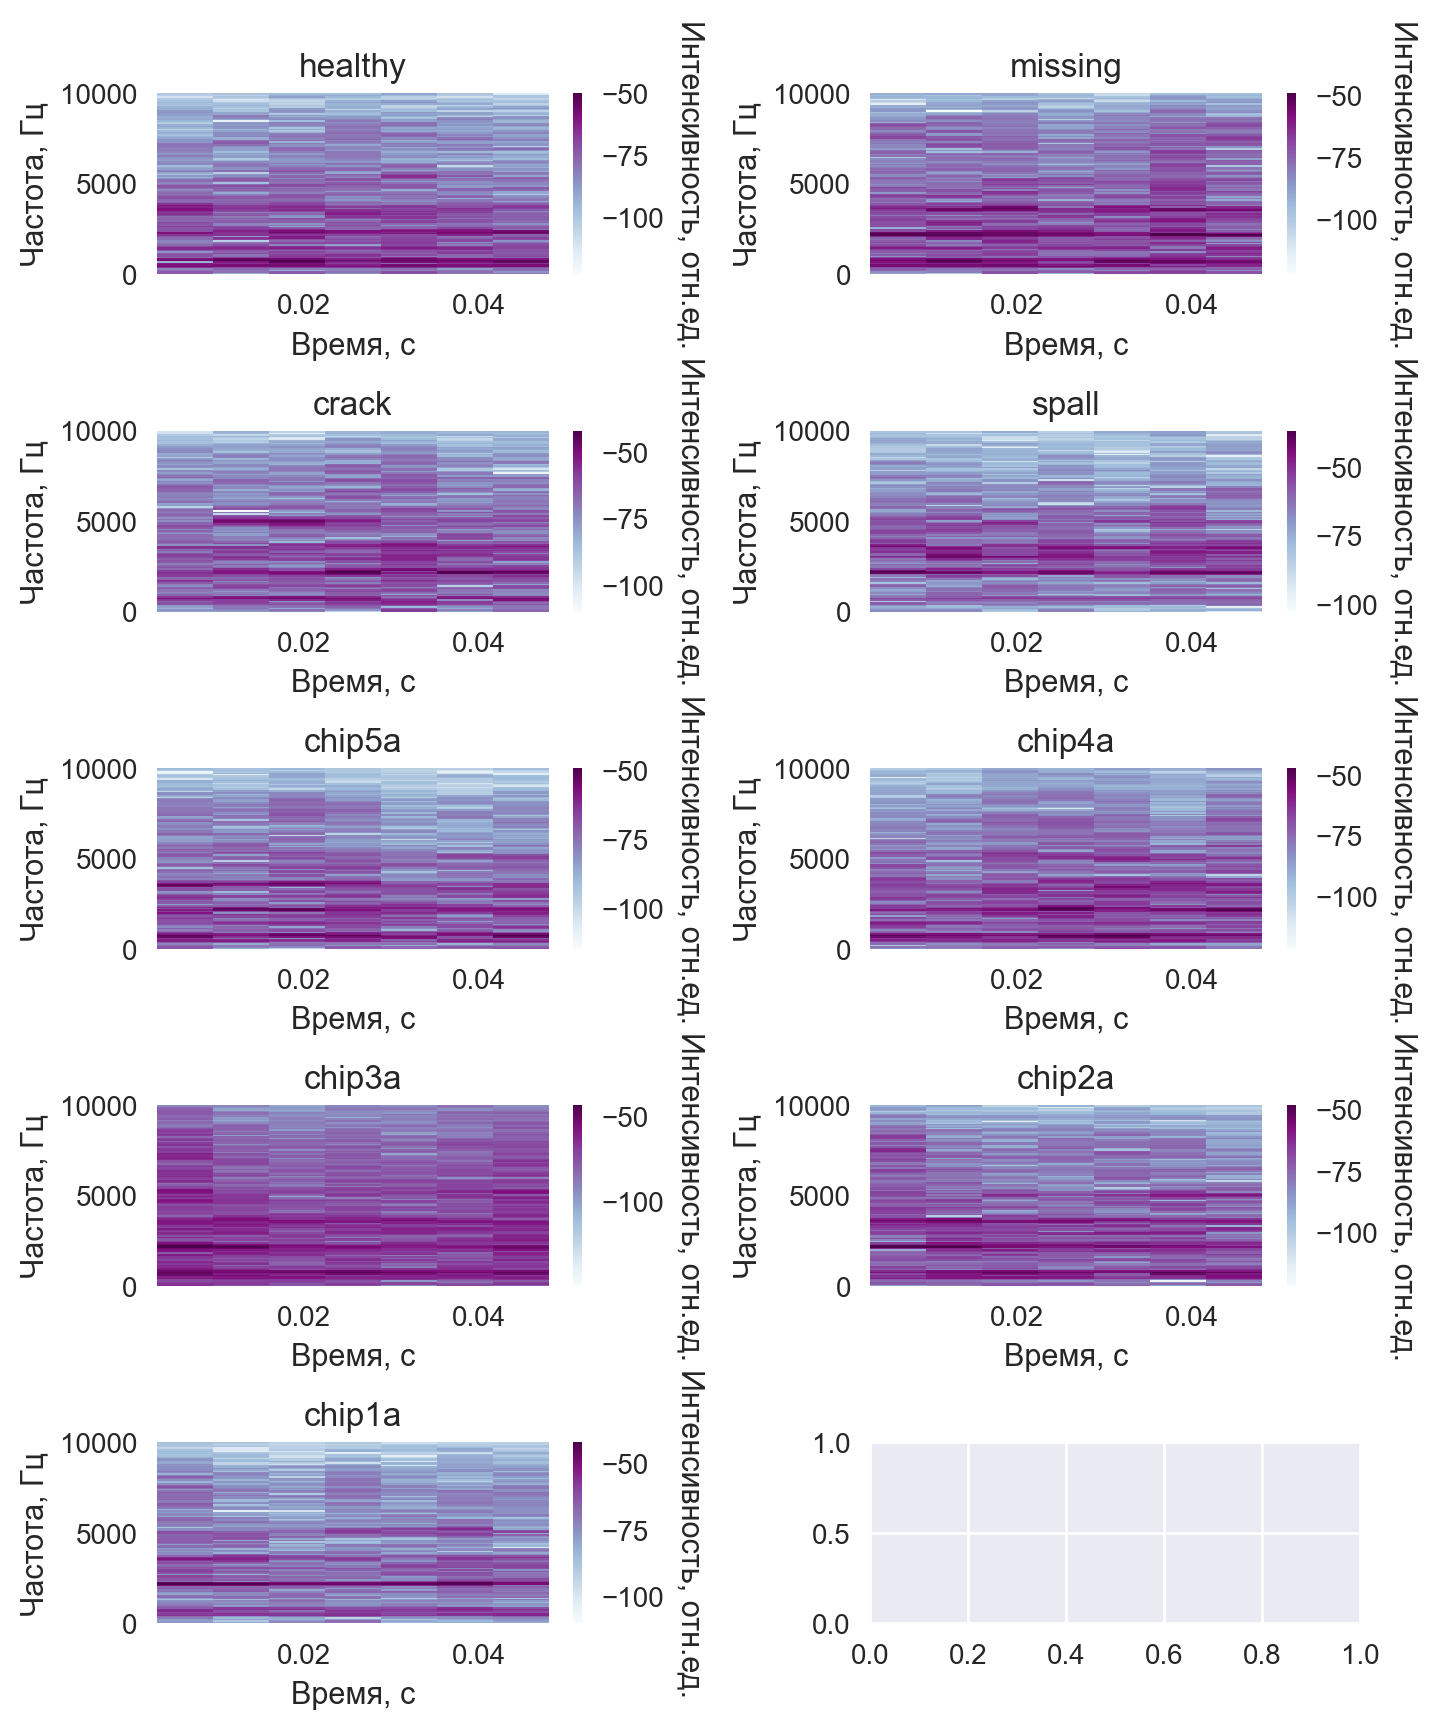

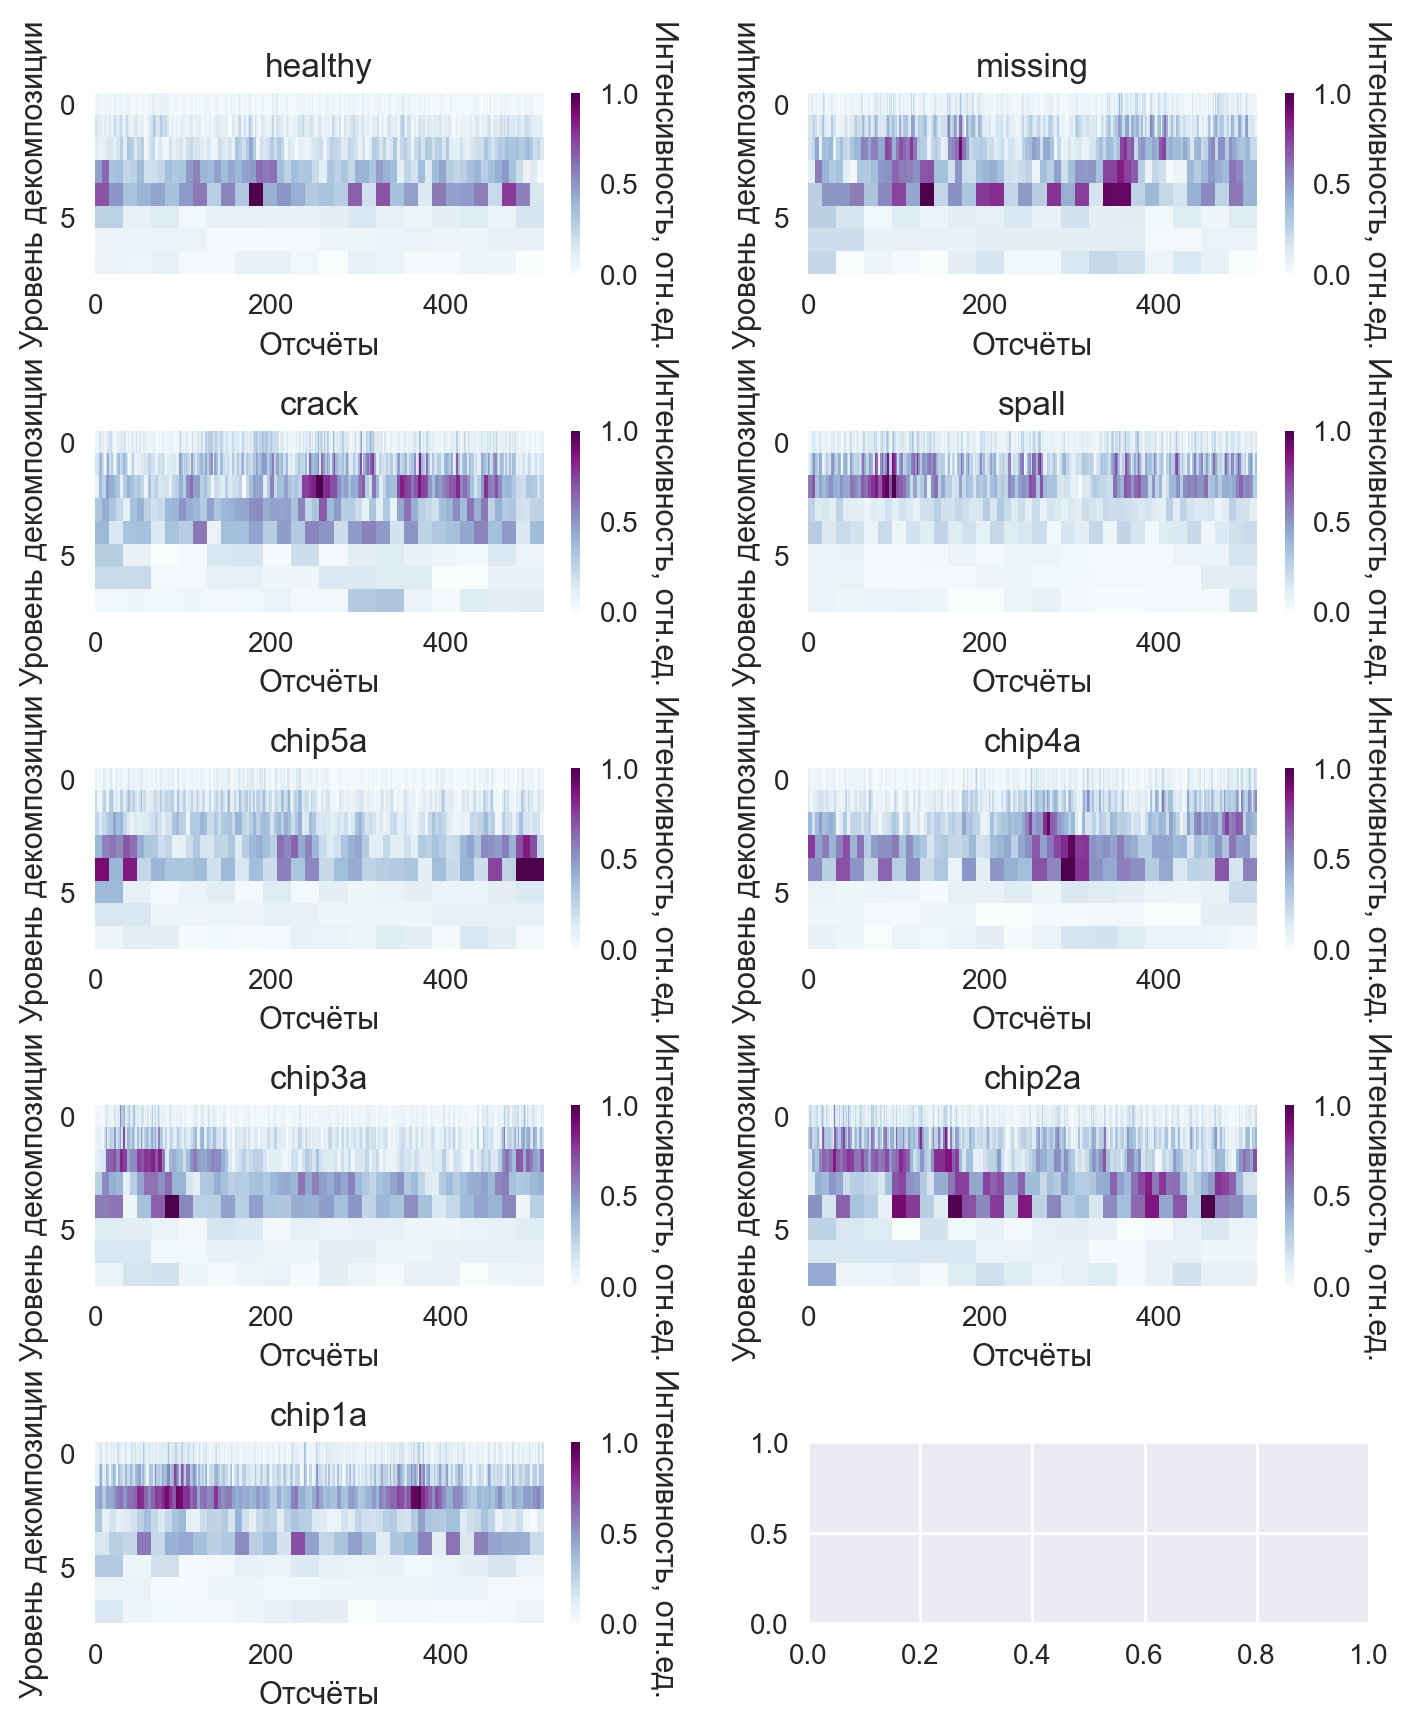

In [775]:
rc = (5, 2)  # rows, columns

figaxs_t = plt.subplots(*rc, figsize=list_sizes['A4'])
figaxs_sp = plt.subplots(*rc, figsize=list_sizes['A4'])
figaxs_dtcwt = plt.subplots(*rc, figsize=list_sizes['A4'])
figaxs_f = plt.subplots(*rc, figsize=list_sizes['A4'])

plot_all(raw_data_cropped, CLASSES, figaxs_t, figaxs_sp, figaxs_dtcwt, figaxs_f, 
         fs=FS, dtcwt_levels=DTCWT_LEVELS, path_prefix=OUT_PATH / 'data1')

## Extract DTCWT

In [677]:
dtcwt_data = save_features(raw_data_cropped, lambda x, fs: features.dtcwt(x, DTCWT_LEVELS, False, True), FS)

class_num = dtcwt_data.shape[0]
samples_per_class = dtcwt_data.shape[1]
feature_shape = dtcwt_data.shape[-2:]

print(dtcwt_data.shape, dtcwt_data.min(), dtcwt_data.max())

Out shape is (9, 312, 8, 512)
processing class 0
processing class 1
processing class 2
processing class 3
processing class 4
processing class 5
processing class 6
processing class 7
processing class 8
(9, 312, 8, 512) 0.0 1.0


## Split train/test

In [678]:
train_test = helpers.ipynb.split_train_test(dtcwt_data, 0.8)
print([a.shape for a in train_test])
train_data, train_labels, val_data, val_labels = train_test

[(2250, 8, 512), (2250, 9), (558, 8, 512), (558, 9)]


# Model

## Define arch

In [636]:
from tensorflow.keras import models, layers

def get_model(feature_shape_, n_classes, name):
    model = models.Sequential(
        [
            layers.Input(shape=(*feature_shape_, 1)),  # 1 is the number of channels

            layers.Conv2D(32, kernel_size=(3, 3)),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Conv2D(10, kernel_size=(2, 2)),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(.1),

            layers.Flatten(),
            layers.Dense(n_classes),
            layers.Softmax(),
        ],
        name=name,
    )
    return model

## Create model

In [637]:
epochs = 50
batch_size = 32
learning_rate = 0.001

model = get_model(feature_shape, len(CLASSES), f'dtcwt_cnn_eps{epochs}_bs{batch_size}_lr{learning_rate}')
model.build()
model.summary()

MODEL_PATH = OUT_PATH / model.name
MODEL_PATH.mkdir(exist_ok=True)
CHECKPOINTS_PATH = MODEL_PATH / 'checkpoints'
CHECKPOINTS_PATH.mkdir(exist_ok=True)

Model: "dtcwt_cnn_eps50_bs32_lr0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1_conv (Conv2D)        (None, 6, 510, 32)        320       
                                                                 
 layer1_relu (ReLU)          (None, 6, 510, 32)        0         
                                                                 
 layer1_pooling (MaxPooling2  (None, 3, 255, 32)       0         
 D)                                                              
                                                                 
 layer2_conv (Conv2D)        (None, 2, 254, 10)        1290      
                                                                 
 layer2_relu (ReLU)          (None, 2, 254, 10)        0         
                                                                 
 layer2_pooling (MaxPooling2  (None, 1, 127, 10)       0         
 D)                                   

## Fit model

In [638]:
# %load_ext tensorboard
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=loss_fn, optimizer=optimizer, metrics='accuracy')

checkpoint = keras.callbacks.ModelCheckpoint(
    CHECKPOINTS_PATH / 'epoch-{epoch}.h5',
    monitor='accuracy',
    save_best_only=False,
    verbose=1,
)
log_dir = MODEL_PATH / 'logs' / ('fit' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x=train_data,
    y=train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_data, val_labels),
    # validation_split=0.8,
    callbacks=[checkpoint],
)

Epoch 1/50
70/71 [============================>.] - ETA: 0s - loss: 1.9589 - accuracy: 0.3295
Epoch 1: saving model to out\gen2\dtcwt_cnn_eps50_bs32_lr0.001\checkpoints\epoch-1.h5
71/71 [==============================] - 8s 92ms/step - loss: 1.9568 - accuracy: 0.3307 - val_loss: 1.3581 - val_accuracy: 0.6918
Epoch 2/50
70/71 [============================>.] - ETA: 0s - loss: 0.8217 - accuracy: 0.7862
Epoch 2: saving model to out\gen2\dtcwt_cnn_eps50_bs32_lr0.001\checkpoints\epoch-2.h5
71/71 [==============================] - 6s 78ms/step - loss: 0.8197 - accuracy: 0.7867 - val_loss: 0.4595 - val_accuracy: 0.9086
Epoch 3/50
70/71 [============================>.] - ETA: 0s - loss: 0.3135 - accuracy: 0.9335
Epoch 3: saving model to out\gen2\dtcwt_cnn_eps50_bs32_lr0.001\checkpoints\epoch-3.h5
71/71 [==============================] - 5s 71ms/step - loss: 0.3130 - accuracy: 0.9333 - val_loss: 0.1844 - val_accuracy: 0.9839
Epoch 4/50
70/71 [============================>.] - ETA: 0s - loss: 0.

## Loss + accuracy

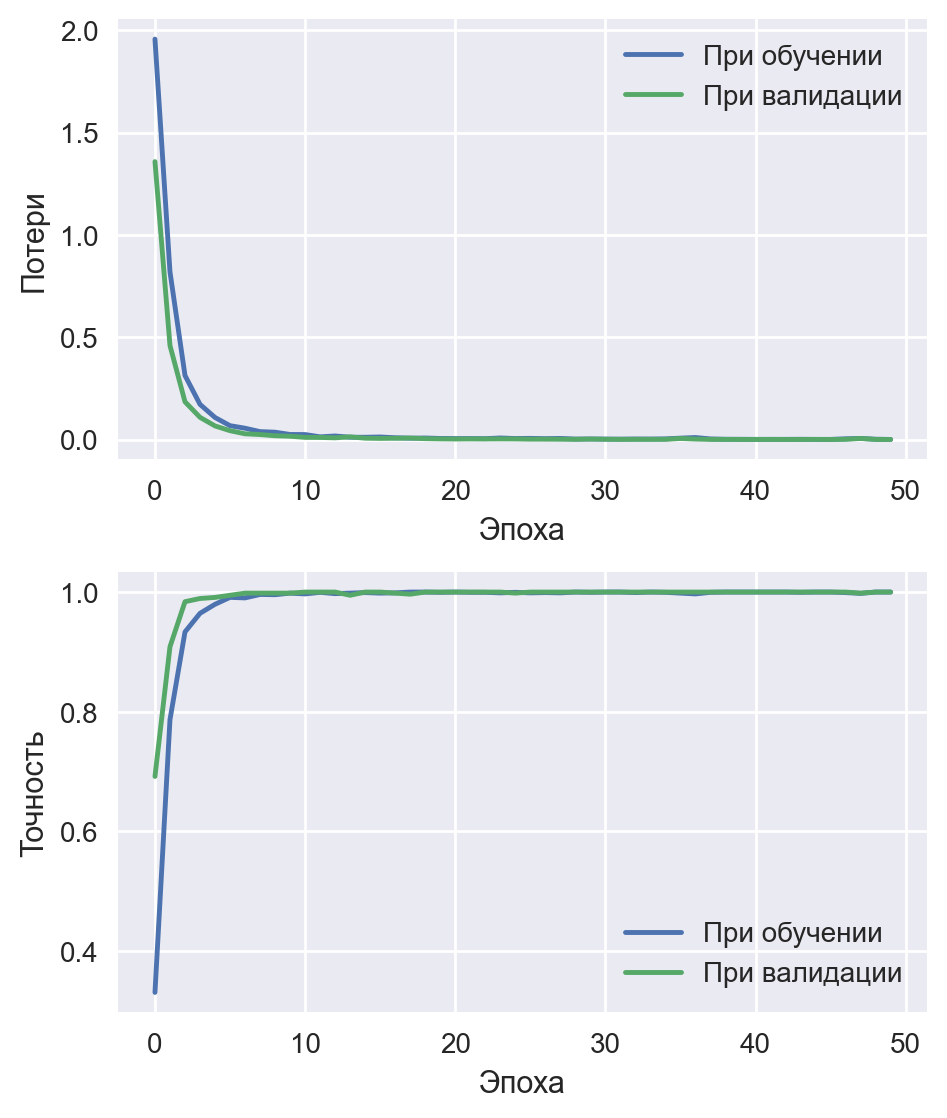

In [639]:
plot_history(history.history, MODEL_PATH)
save_history(history.history, MODEL_PATH)

## Confusion matrix

# Data 2

## Create data array

In [835]:
import dataset_audio as dsr
from collections import defaultdict

DS2_PATH = Path('./data/recorded')
DS2_FS = 25000
DS2_ORIG_SAMPLE_LEN = 1024
DS2_NEW_SAMPLE_LEN = 2048
DS2_LEN_AUDIO = (1499 // (DS2_NEW_SAMPLE_LEN // DS2_ORIG_SAMPLE_LEN)) * DS2_NEW_SAMPLE_LEN
DS2 = defaultdict(lambda: np.array([]))
DS2_1 = defaultdict(lambda: np.array([]))

for filename in DS2_PATH.iterdir():
    if filename.is_file() and filename.suffix == '.wav':
        p, speed, load, *other = filename.stem.split('_')
        fs, data = sio.wavfile.read(filename)
        if data.dtype == np.float64 and fs == DS2_FS:
            # clsname = f'{p=} {speed=} {load=}'
            clsname = '_'.join([p, speed, load])
            if '2' in other:
                d = DS2
            else:
                d = DS2_1
            d[clsname] = np.append(d[clsname], data[:DS2_LEN_AUDIO])
        else:
            print(f'inappropriate format: {data.dtype.name} {fs=} {filename}')
            # if fs > 25000:
            #     if data.dtype == np.int16:
            #         data = data / (2**15-1)
            #     data = librosa.resample(data, orig_sr=fs, target_sr=DS2_FS)
            #     sio.wavfile.write(DS2_PATH / (filename.stem + '_25kHz' + filename.suffix), DS2_FS, data)
            
DS2_CLASSES = sorted(DS2.keys())
ds2_raw_data = np.empty((len(DS2_CLASSES), *list(DS2.values())[0].shape))
for i, cls in enumerate(DS2_CLASSES):
    ds2_raw_data[i] = DS2[cls]
    
print(ds2_raw_data.shape)

DS2_CLASSES = sorted(DS2_1.keys())
ds2_raw_data1 = np.empty((len(DS2_CLASSES), *list(DS2_1.values())[0].shape))
for i, cls in enumerate(DS2_CLASSES):
    ds2_raw_data1[i] = DS2_1[cls]
    
print(ds2_raw_data1.shape)

inappropriate format: int16 fs=44100 data\recorded\6_1500_10.wav
inappropriate format: int16 fs=44100 data\recorded\6_1500_10_2.wav
inappropriate format: int16 fs=44100 data\recorded\6_1500_20.wav
inappropriate format: int16 fs=44100 data\recorded\6_1500_20_2.wav
inappropriate format: int16 fs=44100 data\recorded\6_500_10.wav
inappropriate format: int16 fs=44100 data\recorded\6_500_10_2.wav
inappropriate format: int16 fs=44100 data\recorded\6_500_20.wav
inappropriate format: int16 fs=44100 data\recorded\6_500_20_2.wav
(8, 1533952)
(8, 1533952)


## Fragmentize

In [836]:
ds2_raw_data = ds2_raw_data.reshape(ds2_raw_data.shape[0], -1, DS2_NEW_SAMPLE_LEN)[:, 20:-20, :]
print(ds2_raw_data.shape)
# side 1
ds2_raw_data1 = ds2_raw_data1.reshape(ds2_raw_data1.shape[0], -1, DS2_NEW_SAMPLE_LEN)[:, 20:-20, :]
print(ds2_raw_data1.shape)

(8, 709, 2048)
(8, 709, 2048)


## Plot time, spectre and dtcwt

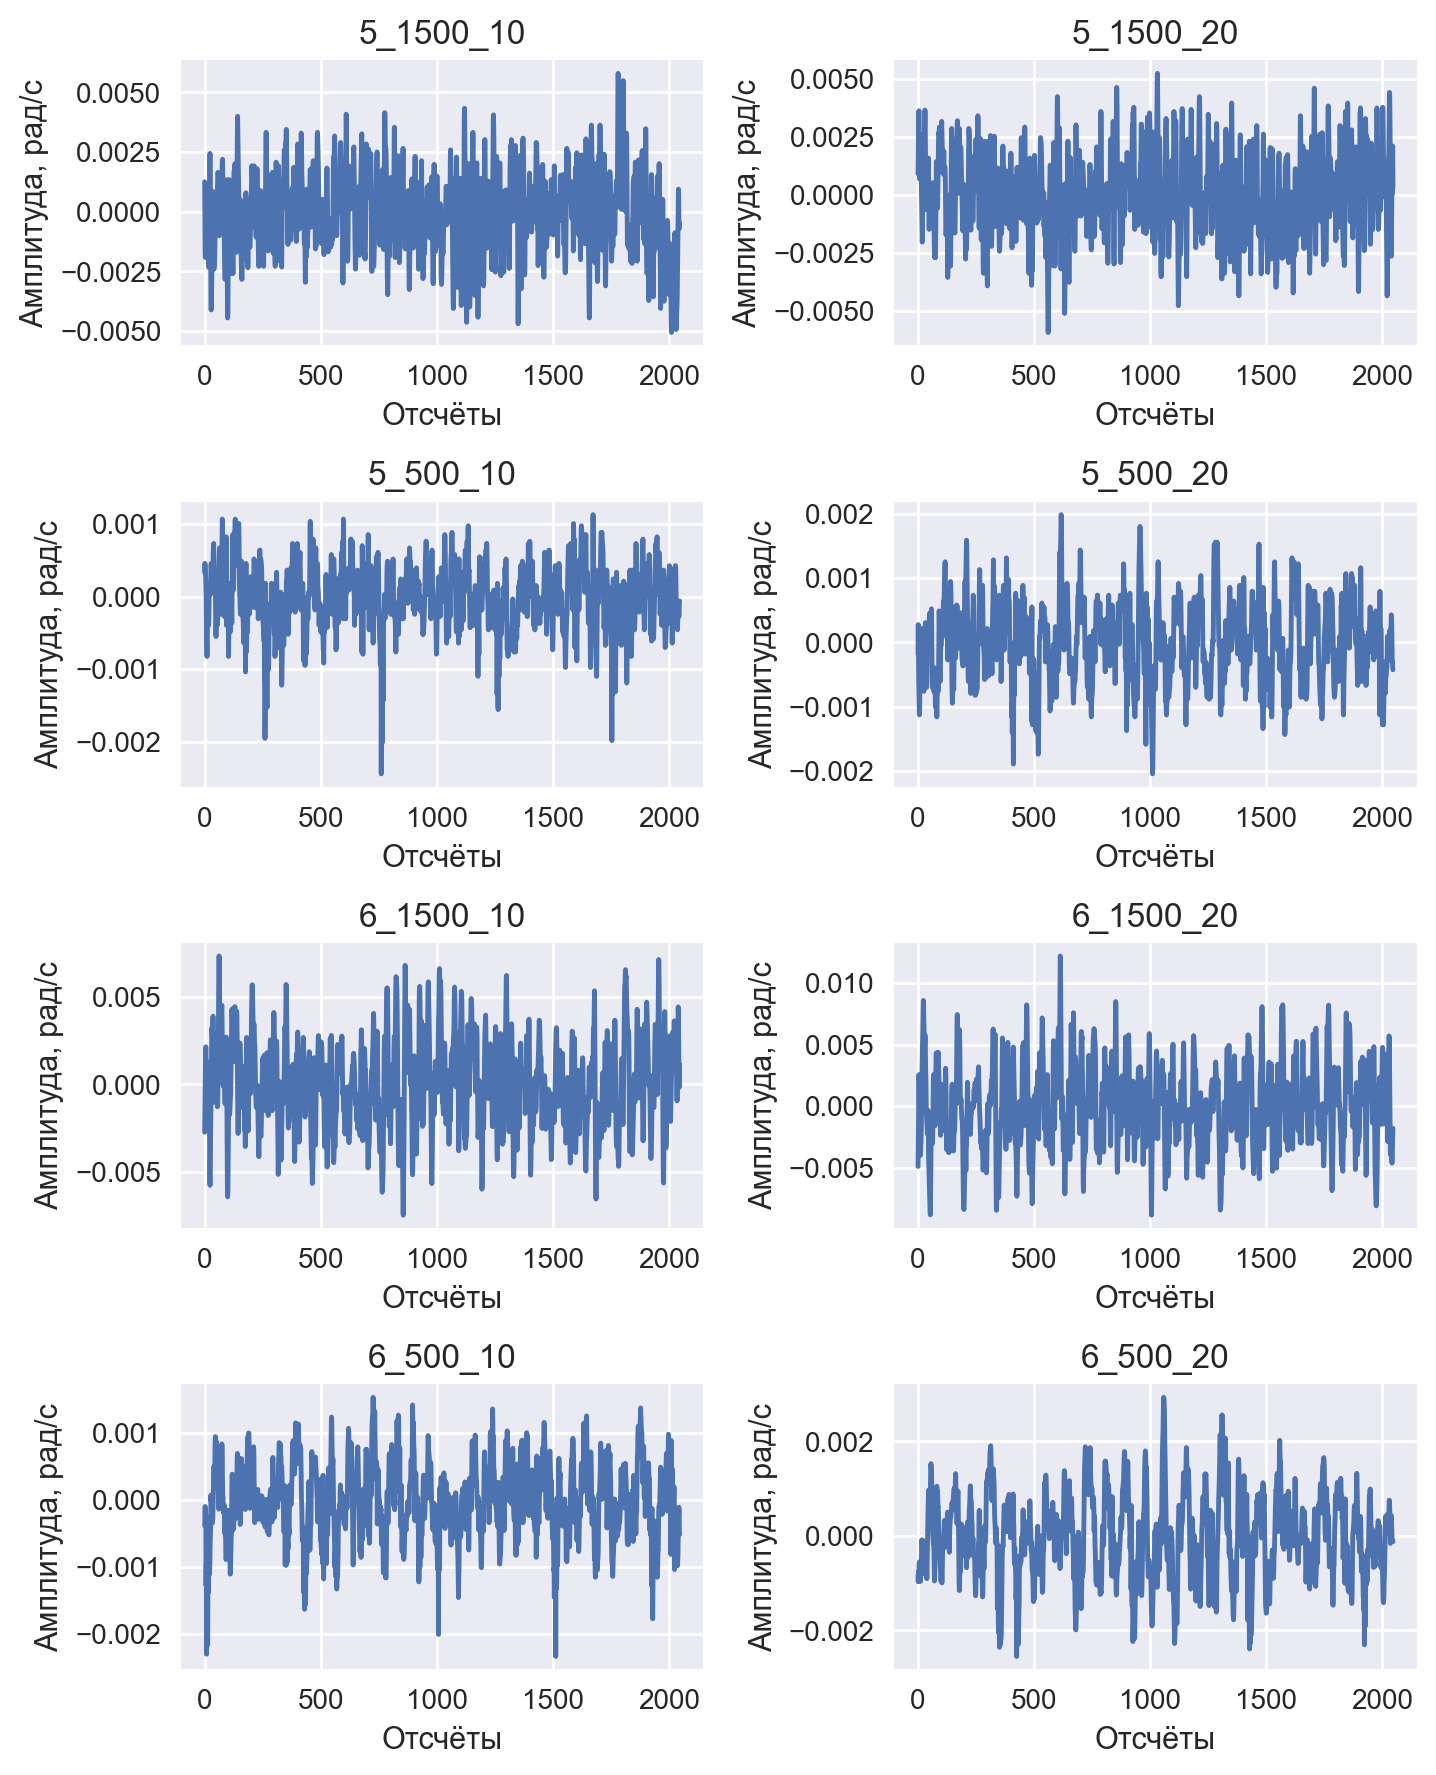

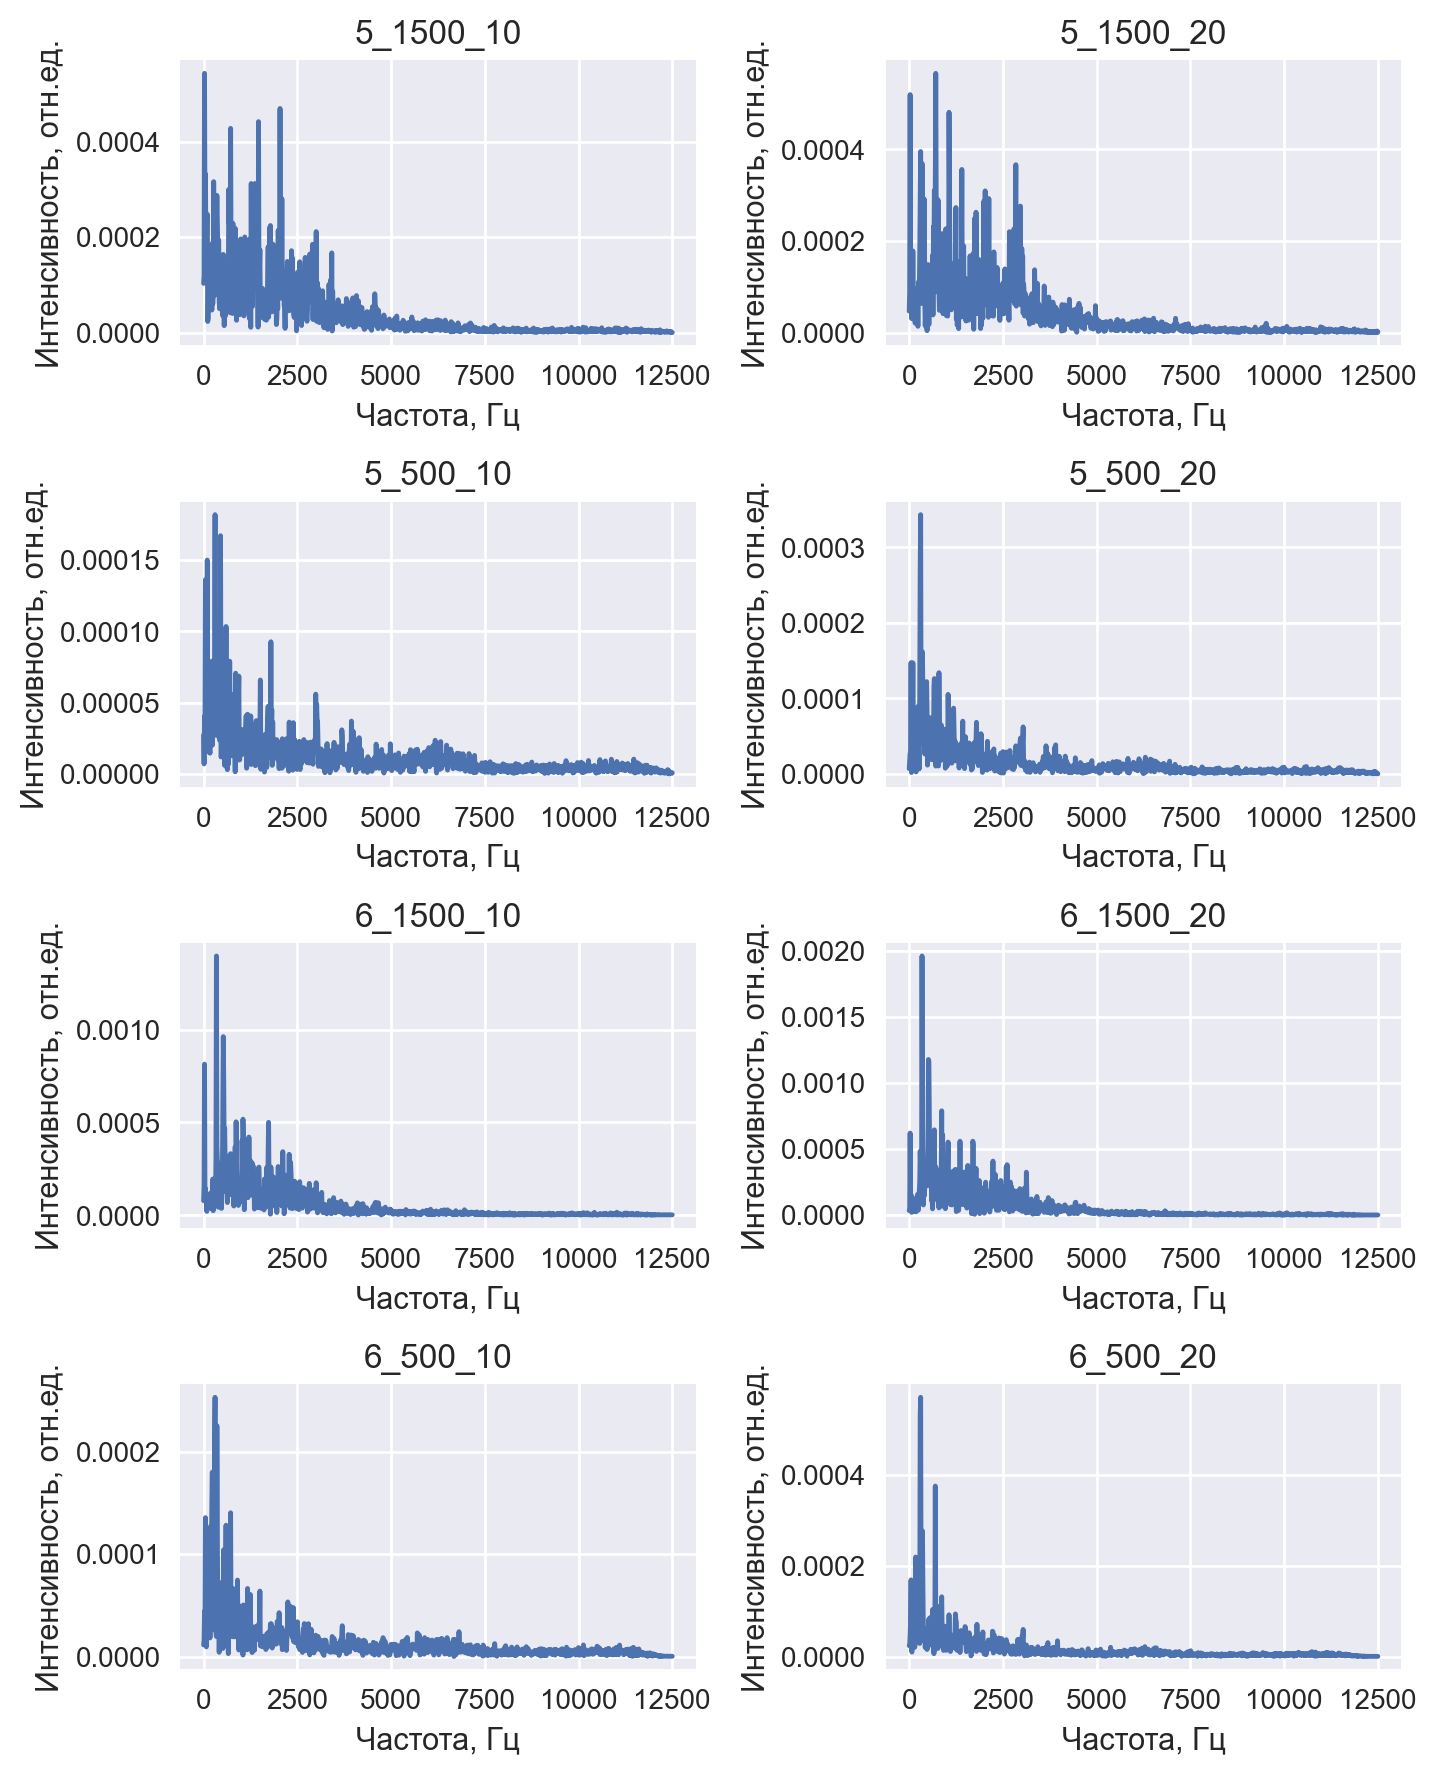

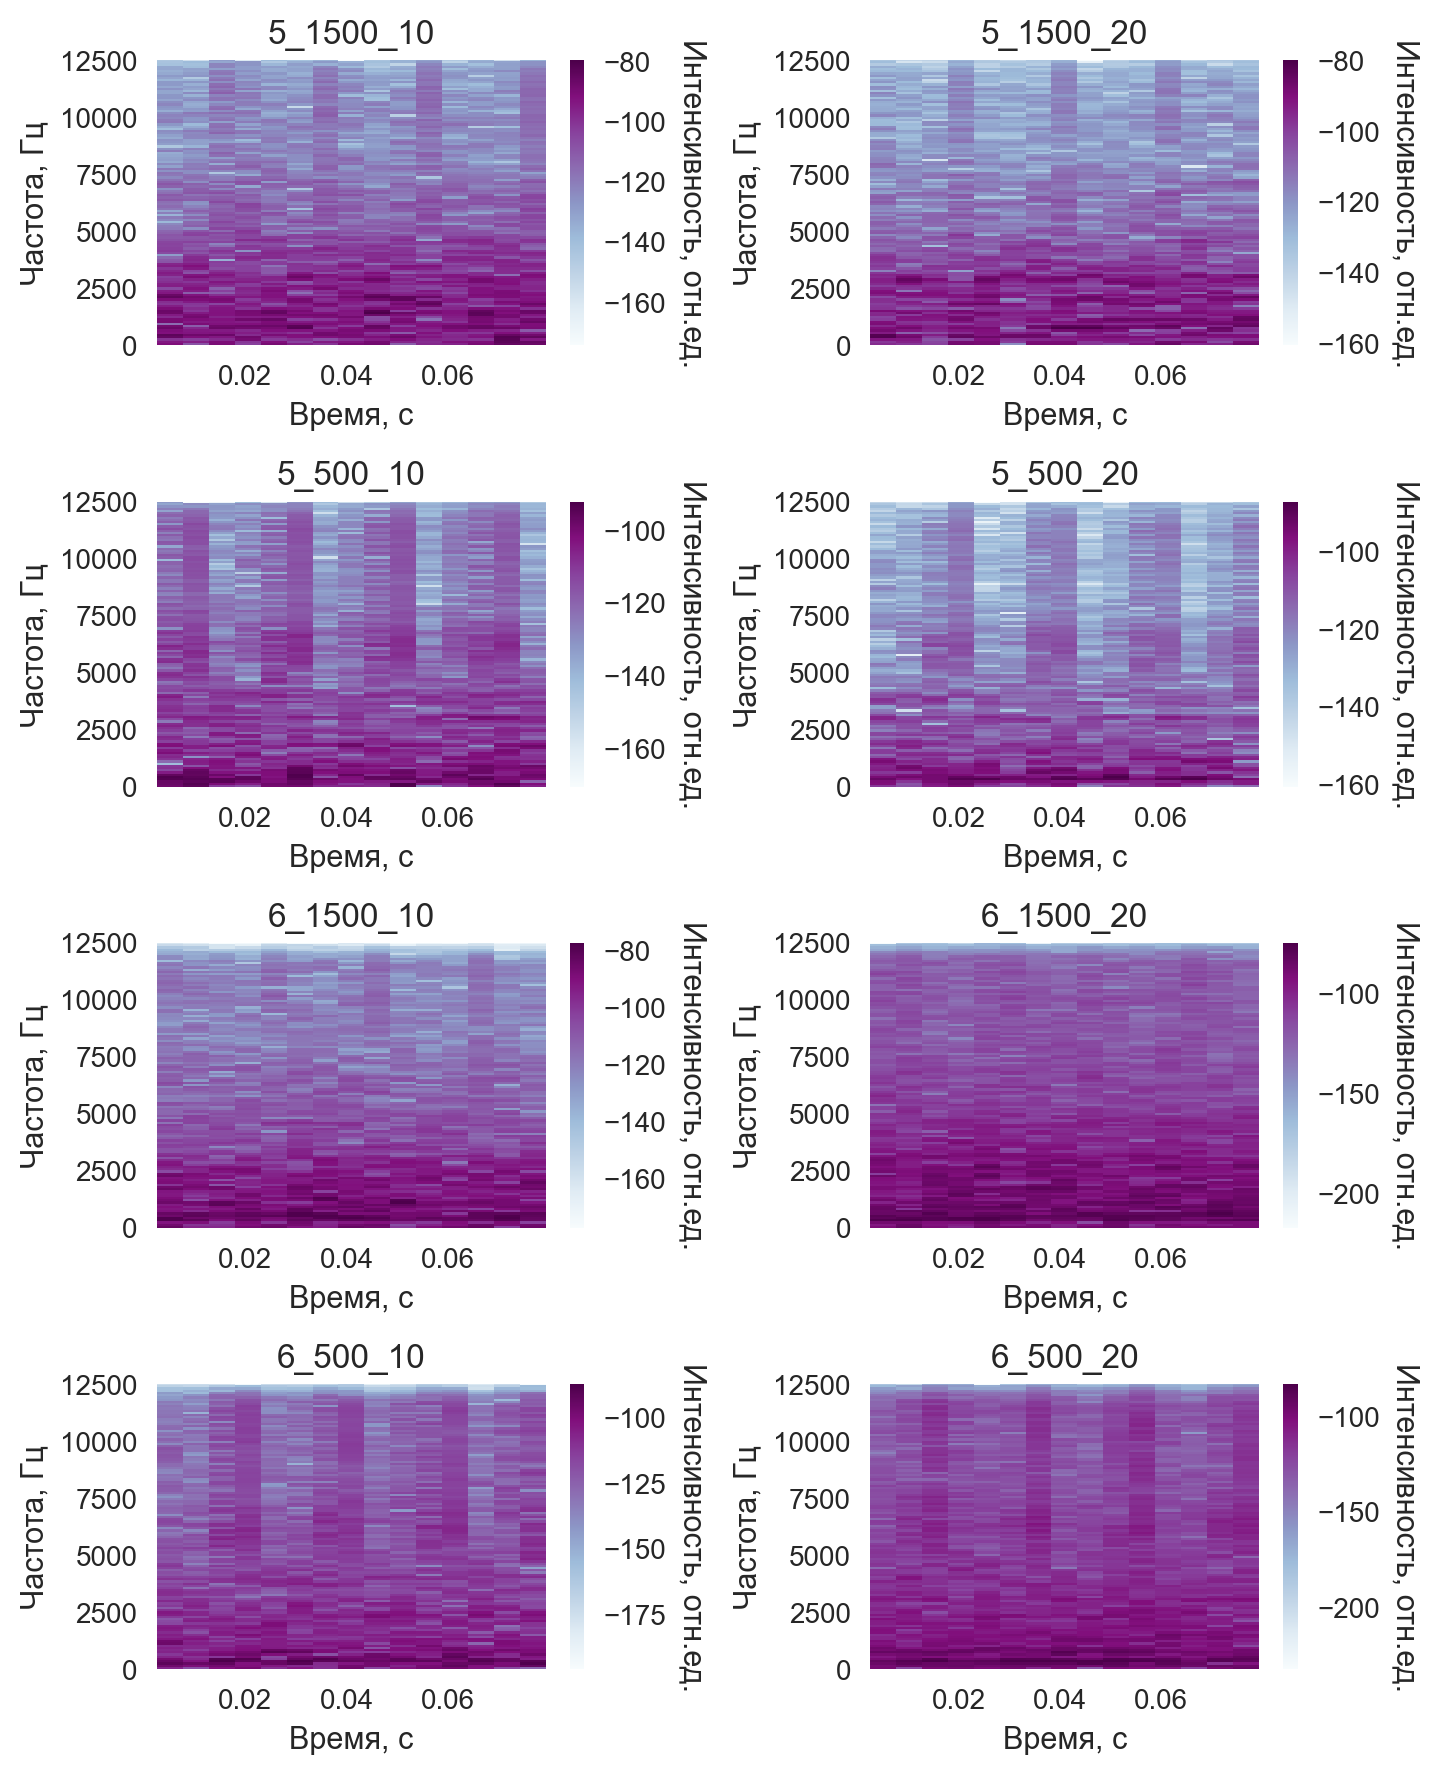

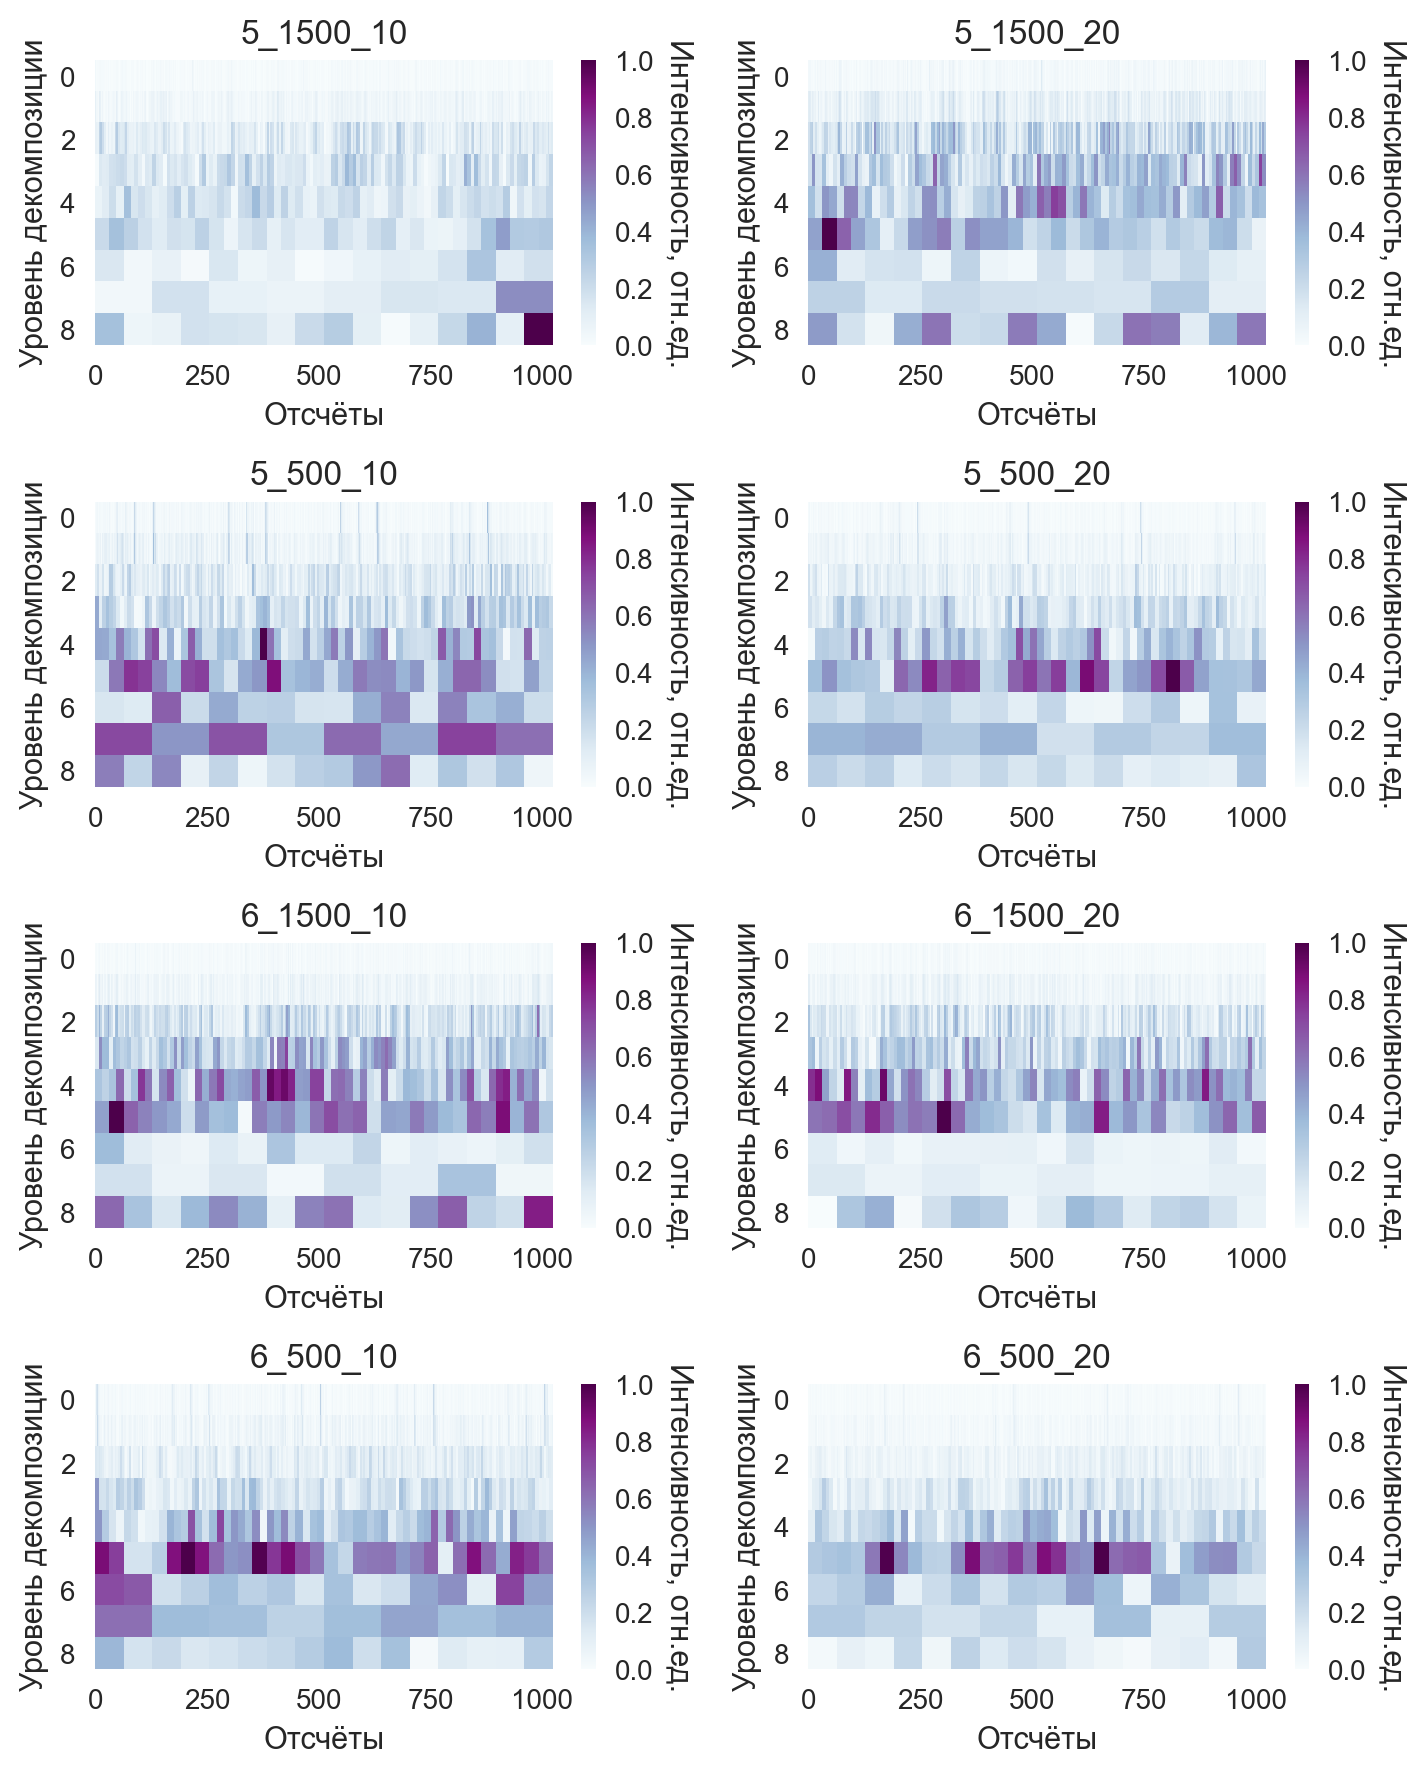

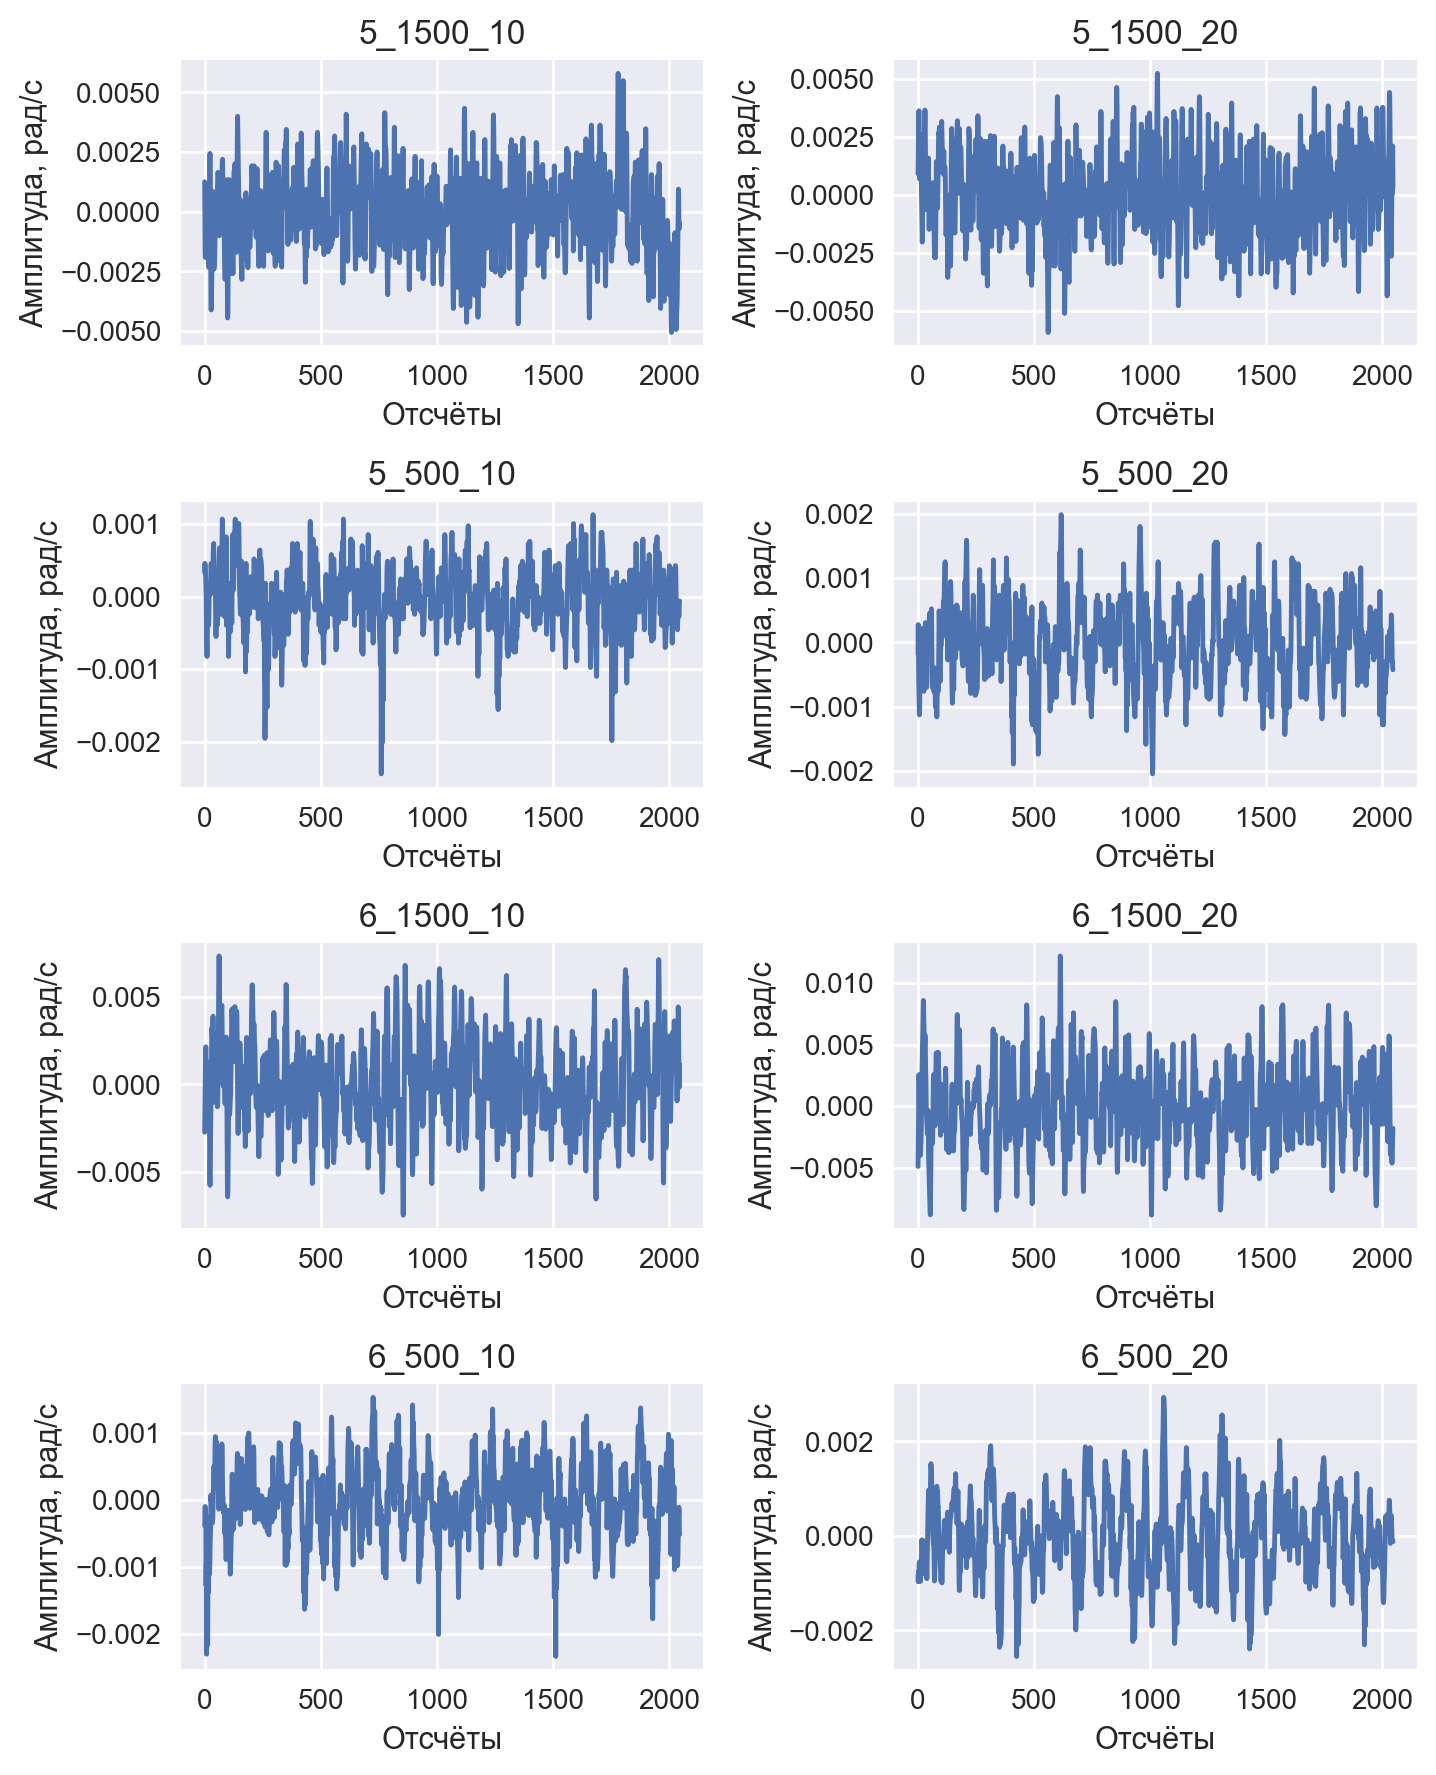

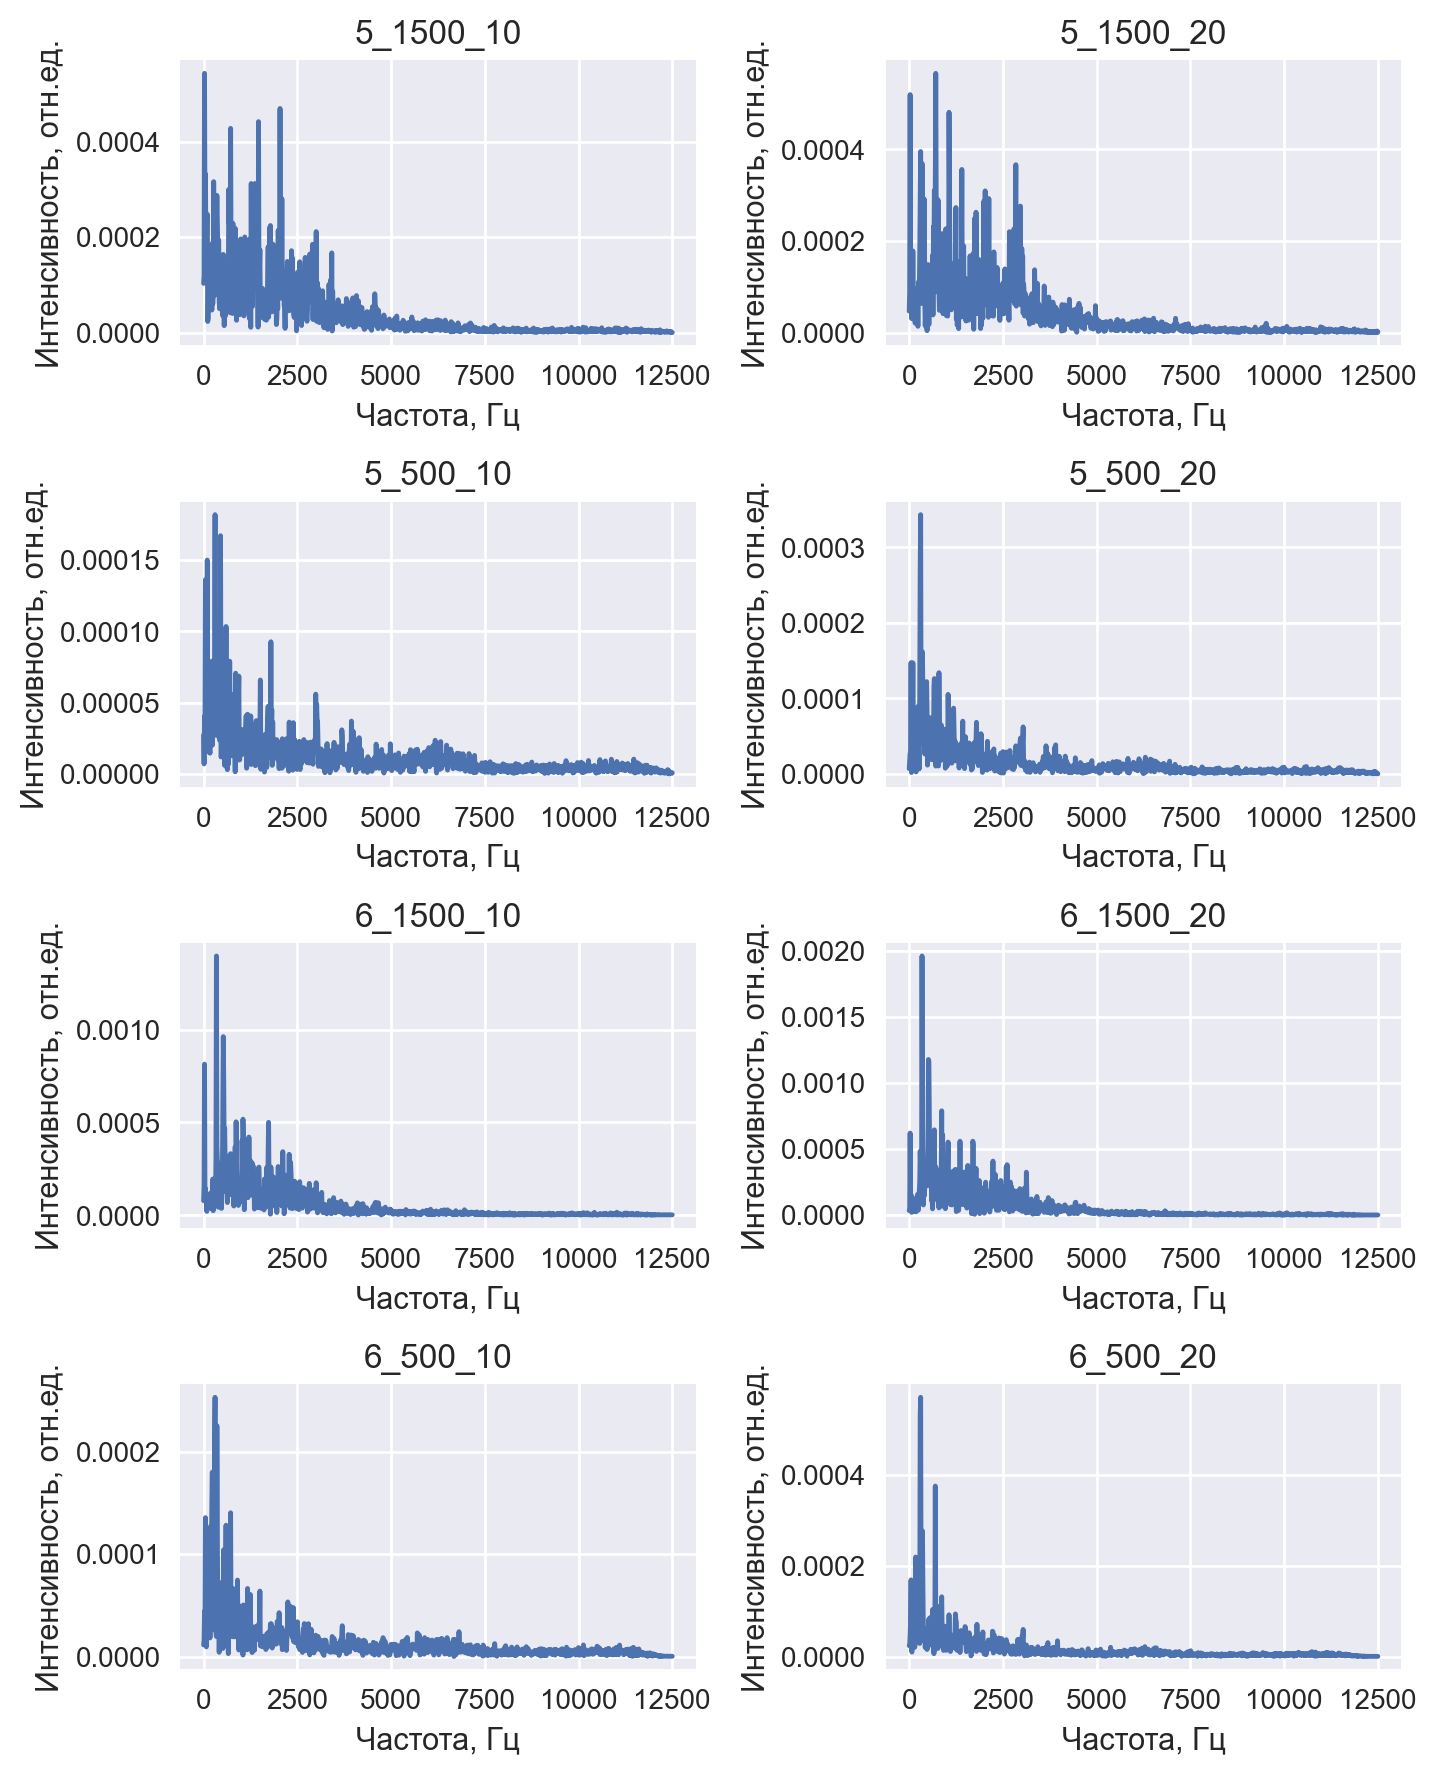

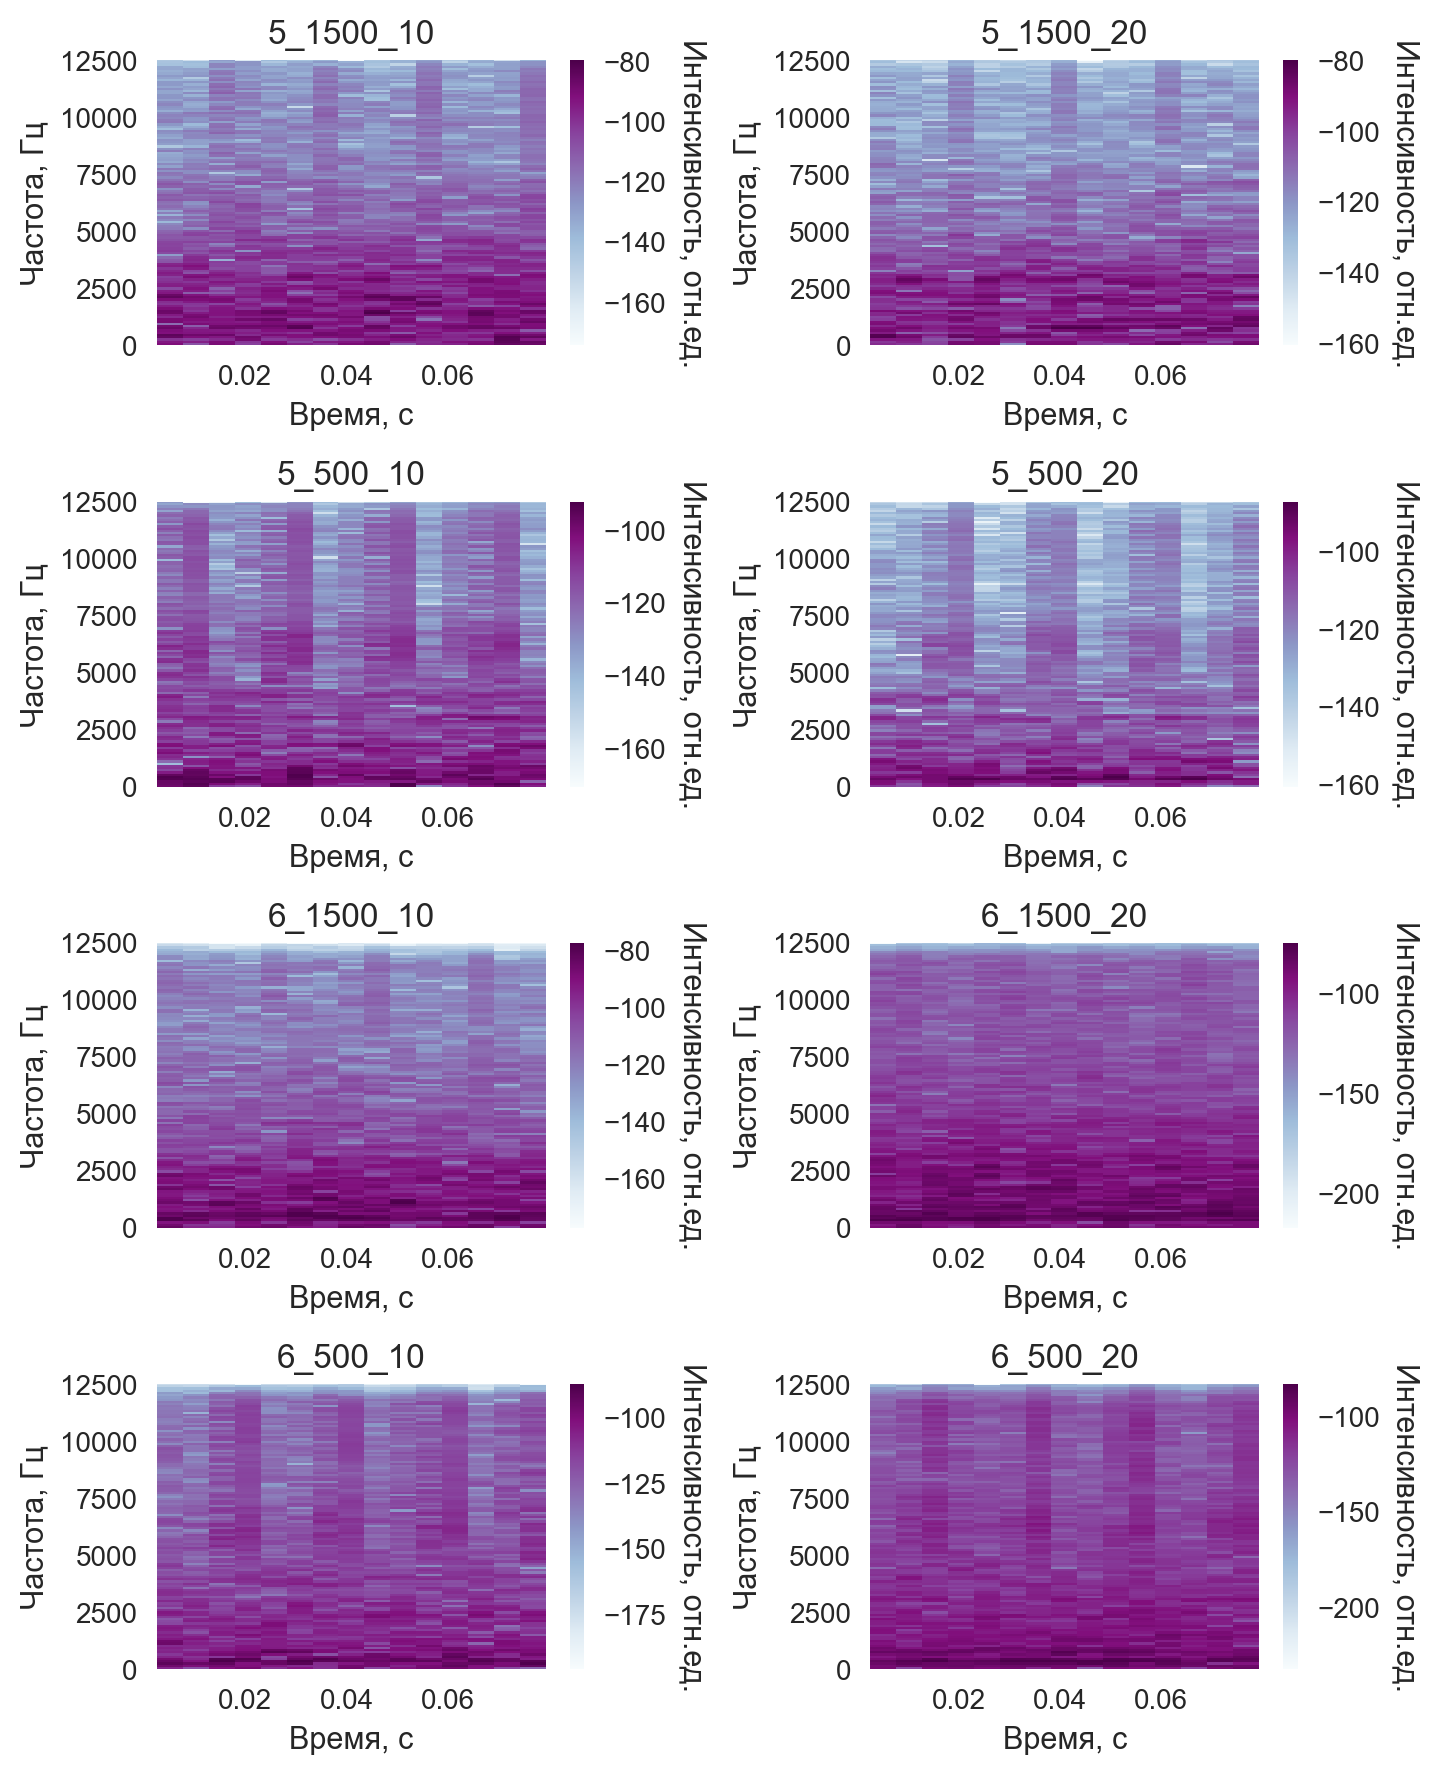

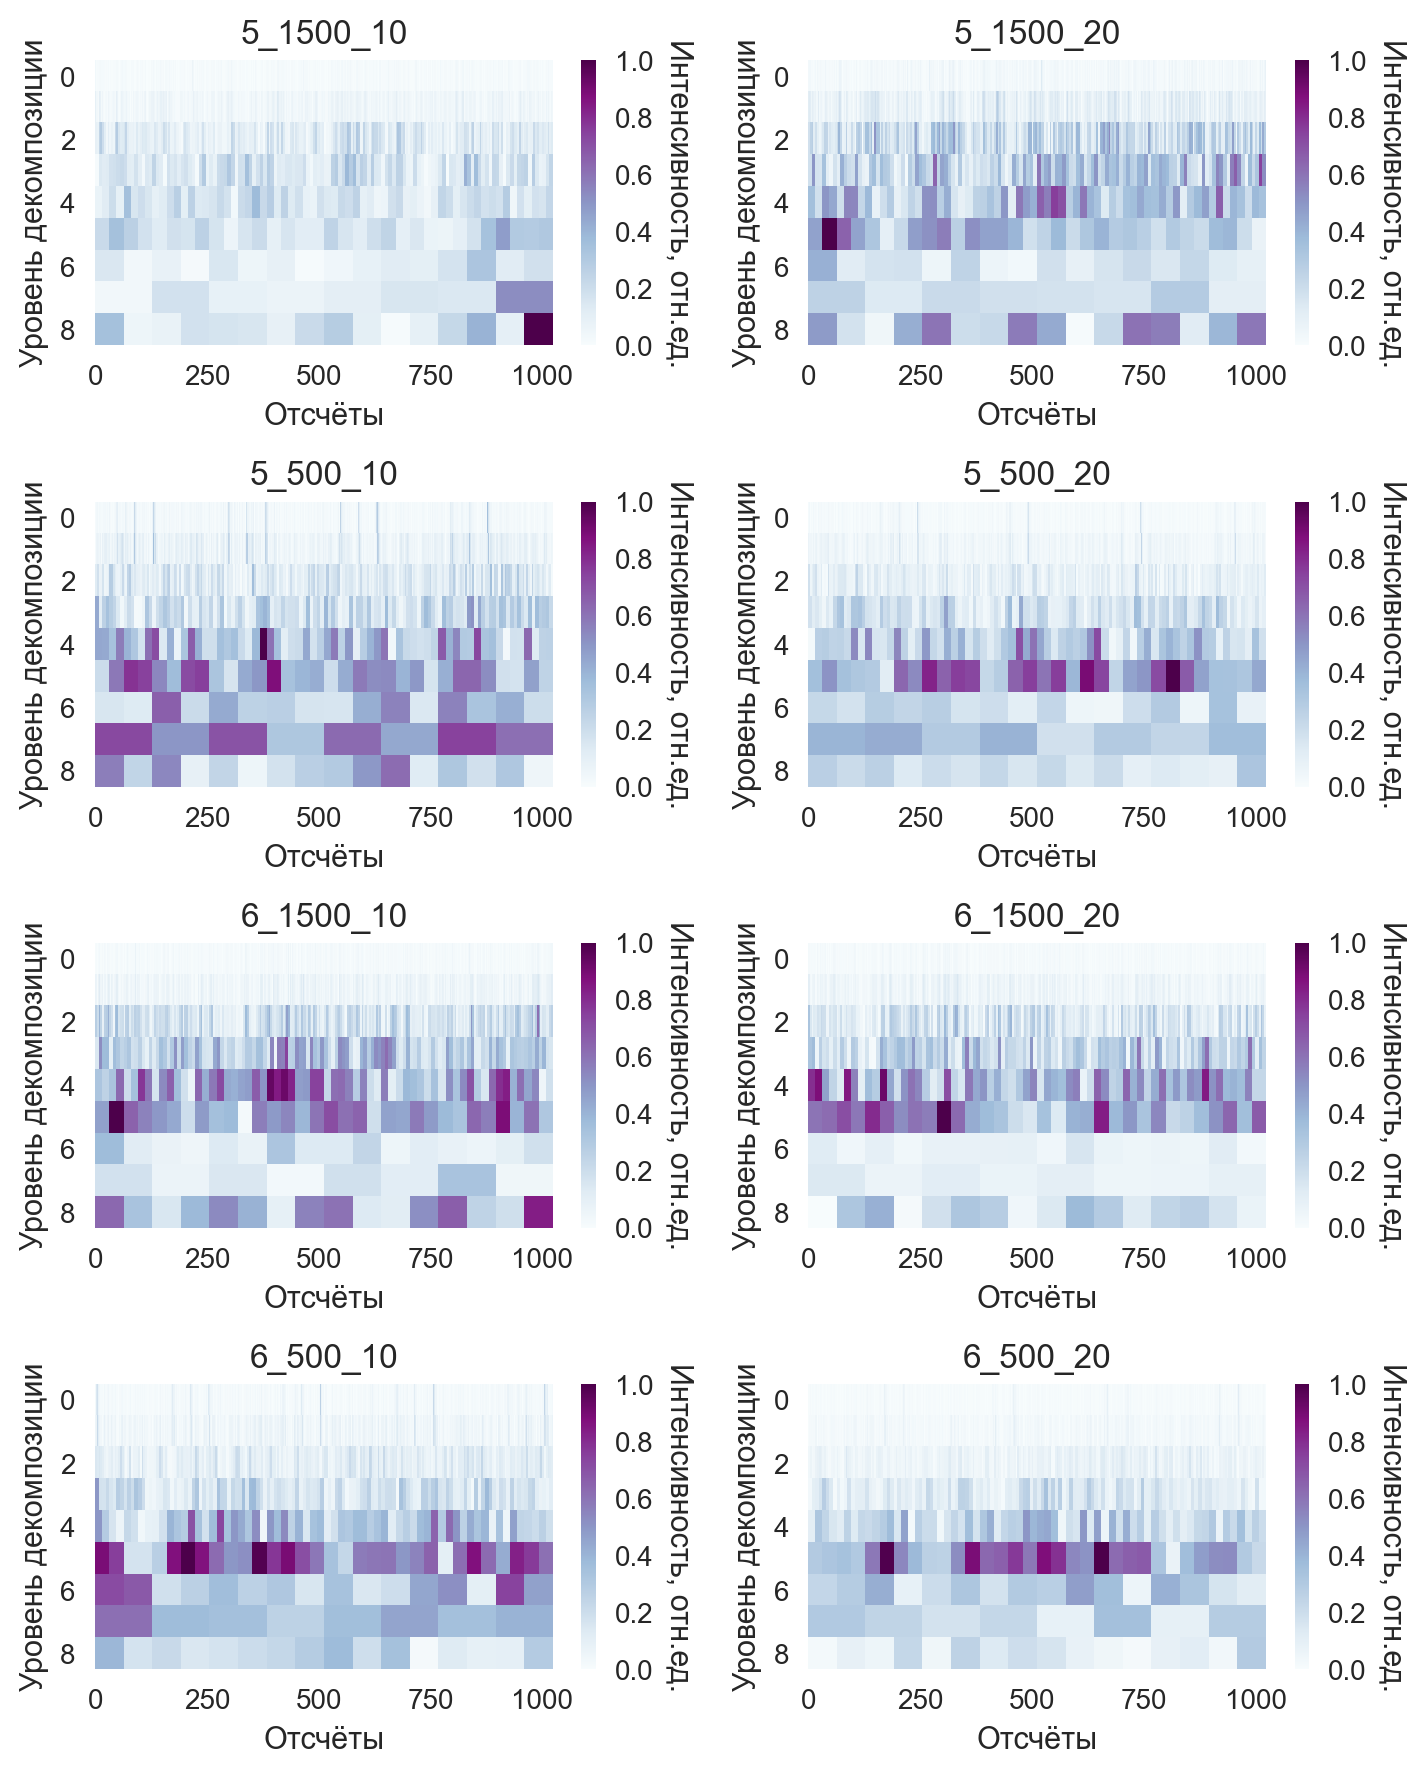

In [837]:
for ds_data, data_name in ((ds2_raw_data, 'data22'), (ds2_raw_data1, 'data21')):
    figaxs_t = plt.subplots(4, 2, figsize=list_sizes['A4'])
    figaxs_sp = plt.subplots(4, 2, figsize=list_sizes['A4'])
    figaxs_dtcwt = plt.subplots(4, 2, figsize=list_sizes['A4'])
    figaxs_f = plt.subplots(4, 2, figsize=list_sizes['A4'])
    
    plot_all(ds2_raw_data, DS2_CLASSES, figaxs_t, figaxs_sp, figaxs_dtcwt, figaxs_f, 
             fs=DS2_FS, dtcwt_levels=8, path_prefix=OUT_PATH / data_name)

## Extract and normalize

In [838]:
ds2_dtcwt_data = save_features(ds2_raw_data, lambda x, fs: dtcwt_feature(x, DS2_DTCWT_LEVELS, False, False), DS2_FS)

Out shape is (8, 709, 8, 1024)
processing class 0
processing class 1
processing class 2
processing class 3
processing class 4
processing class 5
processing class 6
processing class 7


## Split train/test

In [839]:
ds2_train_test = split_train_test(ds2_dtcwt_data, 0.8)
print([a.shape for a in ds2_train_test])
ds2_train_data, ds2_train_labels, ds2_val_data, ds2_val_labels = ds2_train_test

[(4536, 8, 1024), (4536, 8), (1136, 8, 1024), (1136, 8)]


# Model 2

## Define arch

In [648]:
from tensorflow.keras import models, layers

def get_model2(feature_shape_, n_classes, name):
    model = models.Sequential(
        [
            layers.Input(shape=(*feature_shape_, 1)),  # 1 is the number of channels

            layers.Conv2D(32, kernel_size=(3, 3)),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Conv2D(10, kernel_size=(2, 2)),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            
            layers.Dropout(.1),

            layers.Flatten(),
            layers.Dense(n_classes),
            layers.Softmax(),
        ],
        name=name,
    )
    return model

## Create model

In [799]:
ds2_epochs = 50
ds2_batch_size = 32
ds2_learning_rate = 0.001

model = get_model2(ds2_dtcwt_data.shape[-2:], len(DS2_CLASSES), f'model_ds2_side2_8x1024-noorig_c32-10_eps{ds2_epochs}_bs{ds2_batch_size}_lr{ds2_learning_rate}')
model.build()
model.summary()

Model: "model_ds2_side2_8x1024-noorig_c32-10_eps50_bs32_lr0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 6, 1022, 32)       320       
                                                                 
 re_lu_61 (ReLU)             (None, 6, 1022, 32)       0         
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 3, 511, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 2, 510, 10)        1290      
                                                                 
 re_lu_62 (ReLU)             (None, 2, 510, 10)        0         
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 1, 255, 10)       0         
 g2D)      

## Fit model

In [650]:
# %load_ext tensorboard

from keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import datetime

MODEL_PATH = OUT_PATH / model.name
MODEL_PATH.mkdir(exist_ok=True)
CHECKPOINTS_PATH = MODEL_PATH / 'checkpoints'
CHECKPOINTS_PATH.mkdir(exist_ok=True)

loss_fn = CategoricalCrossentropy()
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss=loss_fn, optimizer=optimizer, metrics='accuracy')

checkpoint = ModelCheckpoint(
    CHECKPOINTS_PATH / 'epoch-{epoch}.h5',
    monitor='accuracy',
    save_best_only=False,
    verbose=1,
)
log_dir = OUT_PATH / 'logs' / ('fit' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x=ds2_train_data,
    y=ds2_train_labels,
    epochs=ds2_epochs,
    batch_size=ds2_batch_size,
    validation_data=(ds2_val_data, ds2_val_labels),
    # validation_split=0.8,
    callbacks=[checkpoint],
)
save_history(history.history, MODEL_PATH)

Epoch 1/50
142/142 [==============================] - ETA: 0s - loss: 1.2940 - accuracy: 0.4872
Epoch 1: saving model to out\gen2\model_ds2_side2_8x1024-noorig_c32-10_eps50_bs32_lr0.001\checkpoints\epoch-1.h5
142/142 [==============================] - 32s 217ms/step - loss: 1.2940 - accuracy: 0.4872 - val_loss: 0.6737 - val_accuracy: 0.7562
Epoch 2/50
142/142 [==============================] - ETA: 0s - loss: 0.5996 - accuracy: 0.7795
Epoch 2: saving model to out\gen2\model_ds2_side2_8x1024-noorig_c32-10_eps50_bs32_lr0.001\checkpoints\epoch-2.h5
142/142 [==============================] - 19s 134ms/step - loss: 0.5996 - accuracy: 0.7795 - val_loss: 0.4911 - val_accuracy: 0.8099
Epoch 3/50
142/142 [==============================] - ETA: 0s - loss: 0.4391 - accuracy: 0.8494
Epoch 3: saving model to out\gen2\model_ds2_side2_8x1024-noorig_c32-10_eps50_bs32_lr0.001\checkpoints\epoch-3.h5
142/142 [==============================] - 25s 178ms/step - loss: 0.4391 - accuracy: 0.8494 - val_loss: 0

# Memory calc

In [423]:
default_dtype = tf.keras.backend.floatx()
shapes_mem_count = 0
internal_model_mem_count = 0
for layer in model.layers:
    single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
    out_shape = layer.output_shape
    if isinstance(out_shape, list):
        out_shape = out_shape[0]
    for s in out_shape:
        if s is None:
            continue
        single_layer_mem *= s
    shapes_mem_count += single_layer_mem

trainable_count = sum(
    [tf.keras.backend.count_params(p) for p in model.trainable_weights]
)

print(
    shapes_mem_count,
    trainable_count,
)

1878280 22018


# Results

## Model 1

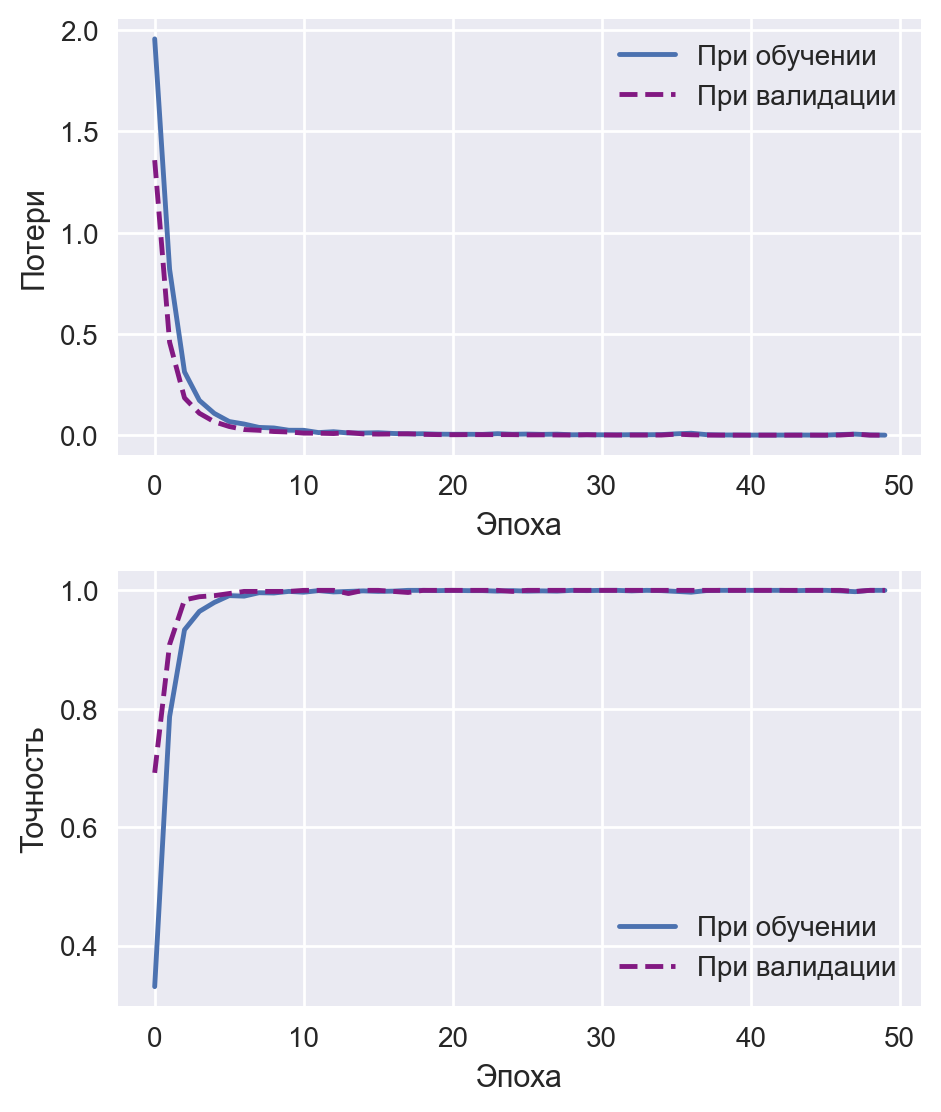

In [758]:
MODEL1_NAME = 'dtcwt_cnn_eps50_bs32_lr0.001'
history_model_1 = np.load(OUT_PATH / MODEL1_NAME / 'history.npz')
plot_history(history_model_1, Path(OUT_PATH / MODEL1_NAME))

In [829]:
v_all_data = np.concatenate((train_data, val_data))
v_all_labels = np.concatenate((train_labels, val_labels))
model_1 = tf.keras.models.load_model(OUT_PATH / MODEL1_NAME / 'checkpoints' / 'epoch-50.h5')
v_pred = model_1.predict(all_data)
v_conf_matrix = confusion_matrix(all_labels.argmax(axis=1), pred.argmax(axis=1))

ValueError: in user code:

    File "C:\Users\Lenovo\AppData\Local\pypoetry\Cache\virtualenvs\diploma-N8xCYB5U-py3.9\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Lenovo\AppData\Local\pypoetry\Cache\virtualenvs\diploma-N8xCYB5U-py3.9\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Lenovo\AppData\Local\pypoetry\Cache\virtualenvs\diploma-N8xCYB5U-py3.9\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Lenovo\AppData\Local\pypoetry\Cache\virtualenvs\diploma-N8xCYB5U-py3.9\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\Lenovo\AppData\Local\pypoetry\Cache\virtualenvs\diploma-N8xCYB5U-py3.9\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Lenovo\AppData\Local\pypoetry\Cache\virtualenvs\diploma-N8xCYB5U-py3.9\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "dtcwt_cnn_eps50_bs32_lr0.001" is incompatible with the layer: expected shape=(None, 8, 512, 1), found shape=(None, 9, 1024)


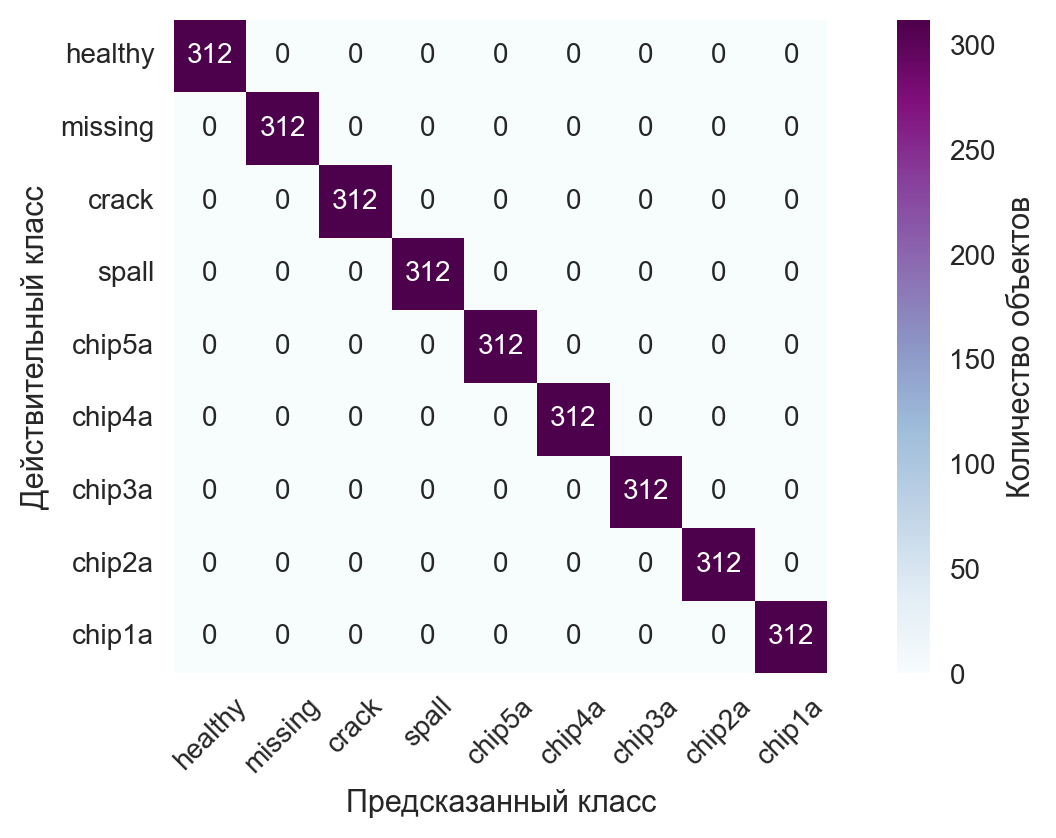

In [759]:
plot_conf_matrix(v_conf_matrix, CLASSES, OUT_PATH / MODEL1_NAME)

## Model 2

In [843]:
MODEL2_NAME = 'model_ds2_side2_8x1024-noorig_c32-10_eps50_bs32_lr0.001'
MODEL2_PATH = OUT_PATH_1 / MODEL2_NAME / 'checkpoints' / 'epoch-50.h5'
model_2 = tf.keras.models.load_model(MODEL2_PATH)
ds2_all_data = np.concatenate((ds2_train_data, ds2_val_data))
ds2_all_labels = np.concatenate((ds2_train_labels, ds2_val_labels))
ds2_pred = model_2.predict(ds2_all_data)
conf_matrix_2 = sklearn.metrics.confusion_matrix(ds2_all_labels.argmax(axis=1), ds2_pred.argmax(axis=1))

0.9959449929478138


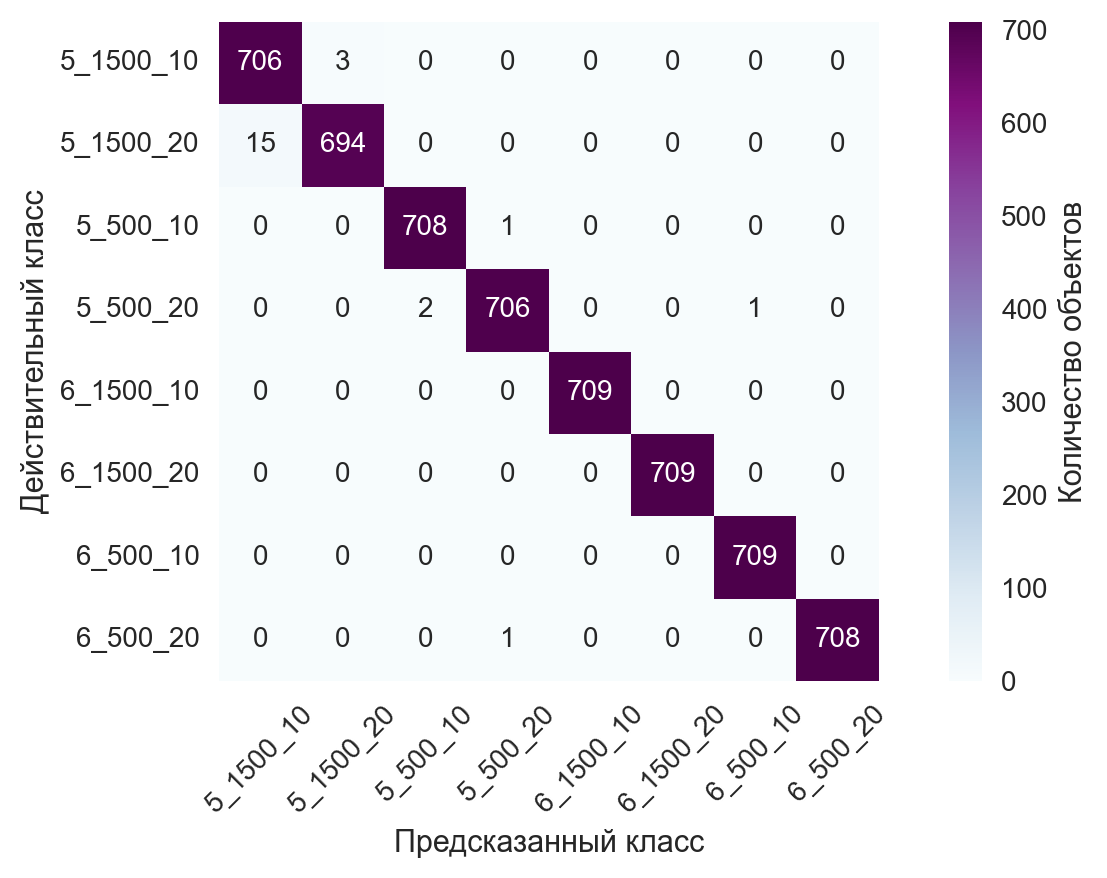

In [878]:
conf_matrix_2 = np.diag([706, 694, 708, 706, 709, 709, 709, 708])
conf_matrix_2[0, 1] = 3
conf_matrix_2[1, 0] = 15
conf_matrix_2[2, 3] = 1
conf_matrix_2[3, 2] = 2
conf_matrix_2[3, 6] = 1
conf_matrix_2[7, 3] = 1
helpers.plot_conf_matrix(conf_matrix_2, DS2_CLASSES, OUT_PATH / MODEL2_NAME)
print(np.sum(conf_matrix_2.diagonal()) / np.sum(conf_matrix_2))

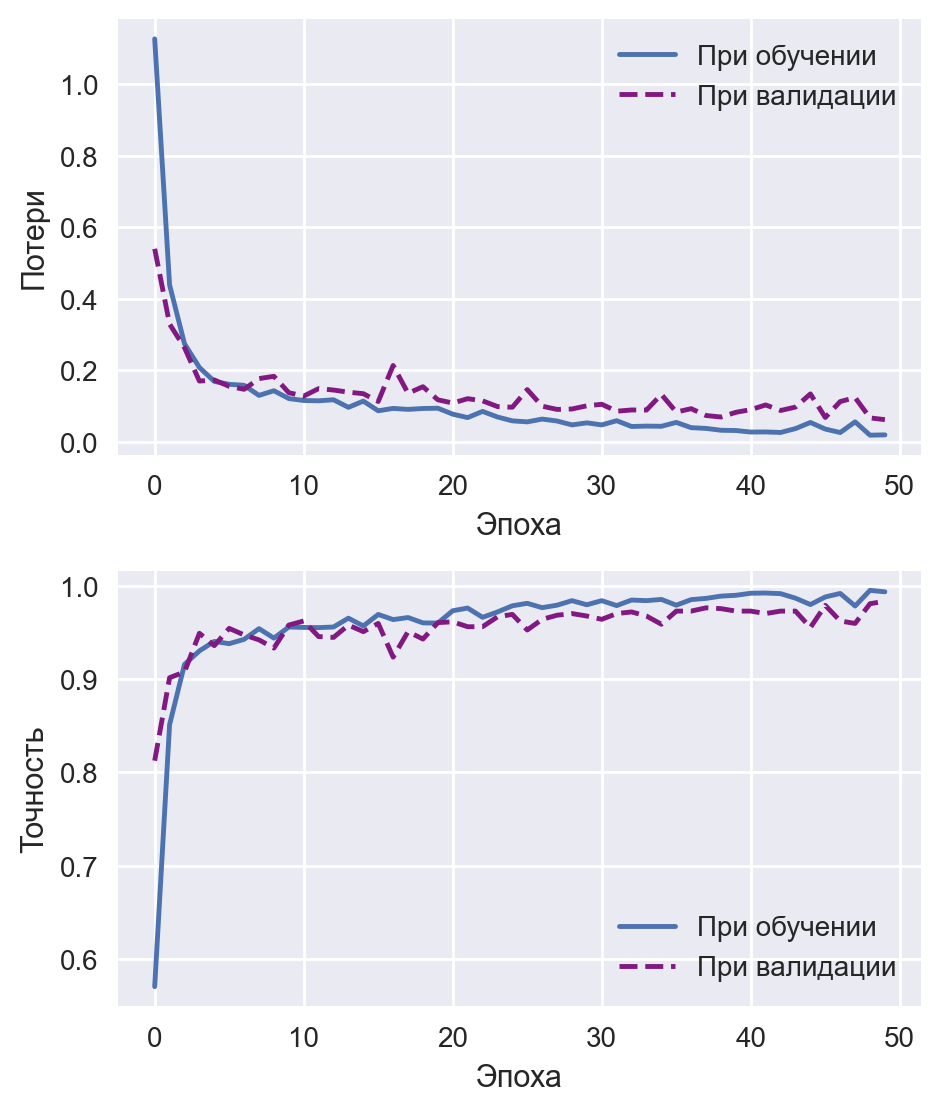

In [764]:
history_model_2 = np.load(OUT_PATH_1 / MODEL2_NAME / 'history.npz')
plot_history(history_model_2, OUT_PATH_1 / MODEL2_NAME)